# Final Pitchbook - Buy Rough, Sell Smooth

- Based on the paper of the same name by Paul Glasserman, Pu He (December 2018)

### Team Members: 
    - Aadi Gupta        - 12449592
    - Mahima Raut       - 12458565
    - Pravallika Reddy  - 12457993
    - Rajdeep Das       - 12451135
    - Roshan Surabhi    - 12455355

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import statsmodels.api as sm
import warnings
from scipy.linalg import eigh
warnings.filterwarnings(action='ignore')
import quandl
import requests
import json
import time
import datetime
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit

# Introduction

# Implementation of H values / Technical Work

## Realized Roughness

### Theory of implementation

### Fractional Brownian Motion
- Rough models of stochastic volatility replace an ordinary Brownian motion driving the dynamics of volatility with a fractional 
Brownian motion (fBM). 
- The fBM family, indexed by a single parameter, includes ordinary Brownian motion and also processes with smoother and rougher paths.
- A fractional Brownian motion with Hurst parameter $H ∈ (0, 1)$ is a mean-zero Gaussian process ${W_t^H , −∞ < t < ∞}$ with stationary increments and covariance function given by
$$
\mathbb{E} \big[ W^H (t) W^H (s) \big] = \frac{1}{2} \Big( |t|^{2H} + |s|^{2H} - |t - s|^{2H} \Big)  \quad\quad -(1)
$$

- The case $H = 1/2$ corresponds to ordinary Brownian motion. With $H ∈ (1/2,1)$, fractional Brownian motion exhibits long-range dependence; processes with $H ∈ (0, 1/2)$ have paths that are rougher than those of ordinary Brownian motion, with small H indicating greater roughness.
- We have the following property of the moments of the increments of fractional Brownian motion. For any $t ∈ R$, and $∆ ≥ 0$, and any $q > 0$,
$$
\mathbb{E} \big[ |W^H_{t+\Delta} - W^H_t|^q \big] = \mathbb{E} \big[ |Z|^q \big] \Delta^ {qH}, 
\quad Z \sim N(0,1)  \quad\quad -(2)
$$

- With smaller H, increments over a short interval ∆ have larger moments.



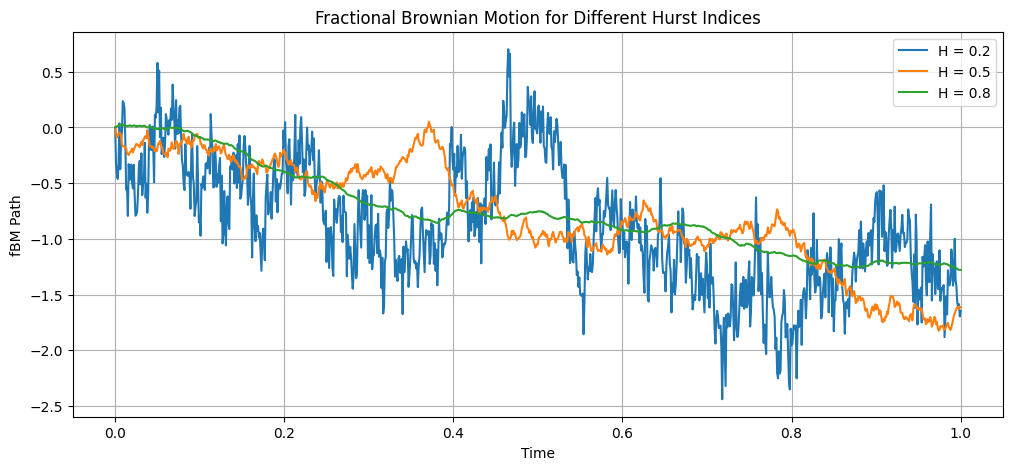

In [3]:
def fbm(T, N, H):
    dt = T / N
    t = np.linspace(0, T, N+1)
    gamma = np.zeros((N+1, N+1))
    for i in range(N+1):
        for j in range(N+1):
            gamma[i, j] = 0.5 * (abs(i * dt)**(2*H) + abs(j * dt)**(2*H) - abs((i-j) * dt)**(2*H))
    eigvals, eigvecs = eigh(gamma)
    eigvals = np.maximum(eigvals, 0) 
    L = eigvecs @ np.diag(np.sqrt(eigvals))
    np.random.seed(42)
    Z = np.random.randn(N+1)
    W = np.dot(L, Z)
    return t, W
T = 1.0   
N = 1000 
H_values = [0.2, 0.5, 0.8]
plt.figure(figsize=(12, 5))
for H in H_values:
    t, W = fbm(T, N, H)
    plt.plot(t, W, label=f"H = {H}")
plt.xlabel("Time")
plt.ylabel("fBM Path")
plt.title("Fractional Brownian Motion for Different Hurst Indices")
plt.legend()
plt.grid()
plt.show(block=True)

### Rough Volatility Model
- As an example of a rough volatility model for an asset price ${St, t ≥ 0}$, we could set

$$
d \log S_t = \mu \, dt + \sigma_t \, dW_t, \quad \quad - (3)
$$
$$
d \log \sigma_t = \nu \, dW_t^H; \quad \quad -(4)
$$

- Here, $μ, κ, m,$ and $ν$ are constants, $W$ is an ordinary Brownian motion, $W^H$ is a fractional Brownian motion with $H ∈ (0,1/2)$, and $W$ and $W^H$ may be correlated. The parameter $H$ determines the roughness of the volatility process.
- Rough volatility arises from mixing mean-reverting volatility processes with different speeds of mean reversion, driven by an ordinary Brownian motion, including components with arbitrarily fast mean reversion.



### One method of estimating realized H values
- If we could observe logσt at times t = 0,∆,2∆,... for some small ∆ > 0, we could estimate H by estimating the below equation for various values of q > 0, and then applying (2) to extract H 

$$
\mathbb{E} \big[ | \log \sigma_{t+\Delta} - \log \sigma_t |^q \big] \quad\quad - (5)
$$



### Implemented methodology of estimating realized H values
- In practice, $σ_t$ cannot be observed and must be estimated, so we proceed as follows. Using trades from the Trade and Quote (TAQ) data, we estimate the daily integrated variance of returns; taking the square root yields our estimated daily volatility.

- The rest of the estimation procedure works with these daily volatilities, which we write as $σ_d$, with $d$ indexing days. We apply (5) with $q = 2$, estimating second moments over intervals of ℓ days, ℓ= 1,2,...,10. In each month, for each stock and each lag ℓ, we calculate (T is the number of days in the month):
$$
z_2(\ell) = \frac{1}{T - \ell} \sum_{d=1}^{T - \ell} \big( \log \hat{\sigma}_{d+\ell} - \log \hat{\sigma}_d \big)^2, \quad\quad -(6)
$$

- Based on (2), we expect
$$
z_2(\ell) \approx \nu^2 \ell^{2H}. \quad\quad -(7)
$$

- So to estimate H we run a regression

$$
\log z_2(\ell) = \beta_1 + \beta_2 \log \ell + \epsilon, \quad\quad -(8)
$$
- We estimate H as $β_2/2$. We also estimate the volatility of volatility $ν$ by setting $log ν = β_1/2$. This procedure yields an estimate of $H$ (and $ν$) for each stock in each month.


### Data import and cleaning

#### Total universe 

- We considered 11 major industries with 10 largest constituent stocks by index weight (as of 31 Dec 2024, src:CRSP) each:

    - US Consumer Discretionary : 	AMZN  TSLA  HD  WMT  MCD  BKNG  LOW  TJX  UBER  SBUX
    - US Consumer Staples : 		COST  PG  KO  PEP  PM  MO  MDLZ  CL  KMB  KVUE
    - US Energy :   			XOM  CVX  COP  EOG  WMB  OKE  SLB  KMI  PSX  LNG
    - US Financials : 			BRK.A/BRK.B  JPM  V  MA  BAC  WFC  GS  SPGI  MS  AXP
    - US Healthcare :			LLY  UNH  JNJ  ABBV  MRK  TMO  ABT  ISRG  PFE  DHR
    - US Industrials :			ACN  CAT  GE  RTX  HON  UNP  BA  ETN  ADP  LMT
    - US Materials :			LIN  SHW  APD  ECL  FCX  NEM  VMC  MLM  DD  DOW
    - US Media & Communications :  	GOOGL  META  NFLX  DIS  T  VZ  CMCSA  TMUS  EA  RBLX
    - US Real Estate & REITs :		PLD  EQIX  AMT  WELL  DLR  SPG  PSA  O  CBRE  CCI
    - US Technology : 			AAPL  MSFT  NVDA  AVGO  CRM  ORCL  NOW  CSCO  IBM  AMD
    - US Utilities :				NEE  SO  DUK  CEG  SRE  AEP  VST  D  PCG  PEG

In [4]:
industries = pd.read_csv('./industry.csv')
industries['industry'] = industries.industry.str.replace('CRSP ', '', regex=True)
industries['industry'] = industries.industry.str.replace(' Index', '', regex=True)
industries['top_tickers'] = industries['top_tickers'].str.split()
industries = industries.explode('top_tickers').reset_index(drop=True)
industries.head()

industry top_tickers
0  US Consumer Discretionary        AMZN
1  US Consumer Discretionary        TSLA
2  US Consumer Discretionary          HD
3  US Consumer Discretionary         WMT
4  US Consumer Discretionary         MCD

In [16]:
vols = pd.read_csv('./Realized_H/daily_vol_series.csv')
vols = vols[vols['SYM_ROOT'] == vols['symbol']]
vols = vols.merge(industries, left_on='SYM_ROOT', right_on='top_tickers', how='inner')
vols = vols[['DATE', 'SYM_ROOT', 'industry', 'ivol_t', 'ivol_q']]
vols = vols[vols['DATE'] <= '2023-08-31']
vols.head()

DATE SYM_ROOT       industry        ivol_t        ivol_q
0  2010-01-04     AAPL  US Technology  6.140084e-09  4.300400e-10
1  2010-01-05     AAPL  US Technology  5.997564e-09  3.934783e-10
2  2010-01-06     AAPL  US Technology  5.785301e-09  5.765893e-10
3  2010-01-07     AAPL  US Technology  9.102045e-09  6.425180e-10
4  2010-01-08     AAPL  US Technology  6.838924e-09  5.694237e-10

In [19]:
vols['month'] = pd.to_datetime(vols['DATE']).dt.month
vols['year'] = pd.to_datetime(vols['DATE']).dt.year
vols['ivol_q_log'] = np.log(vols['ivol_q'])

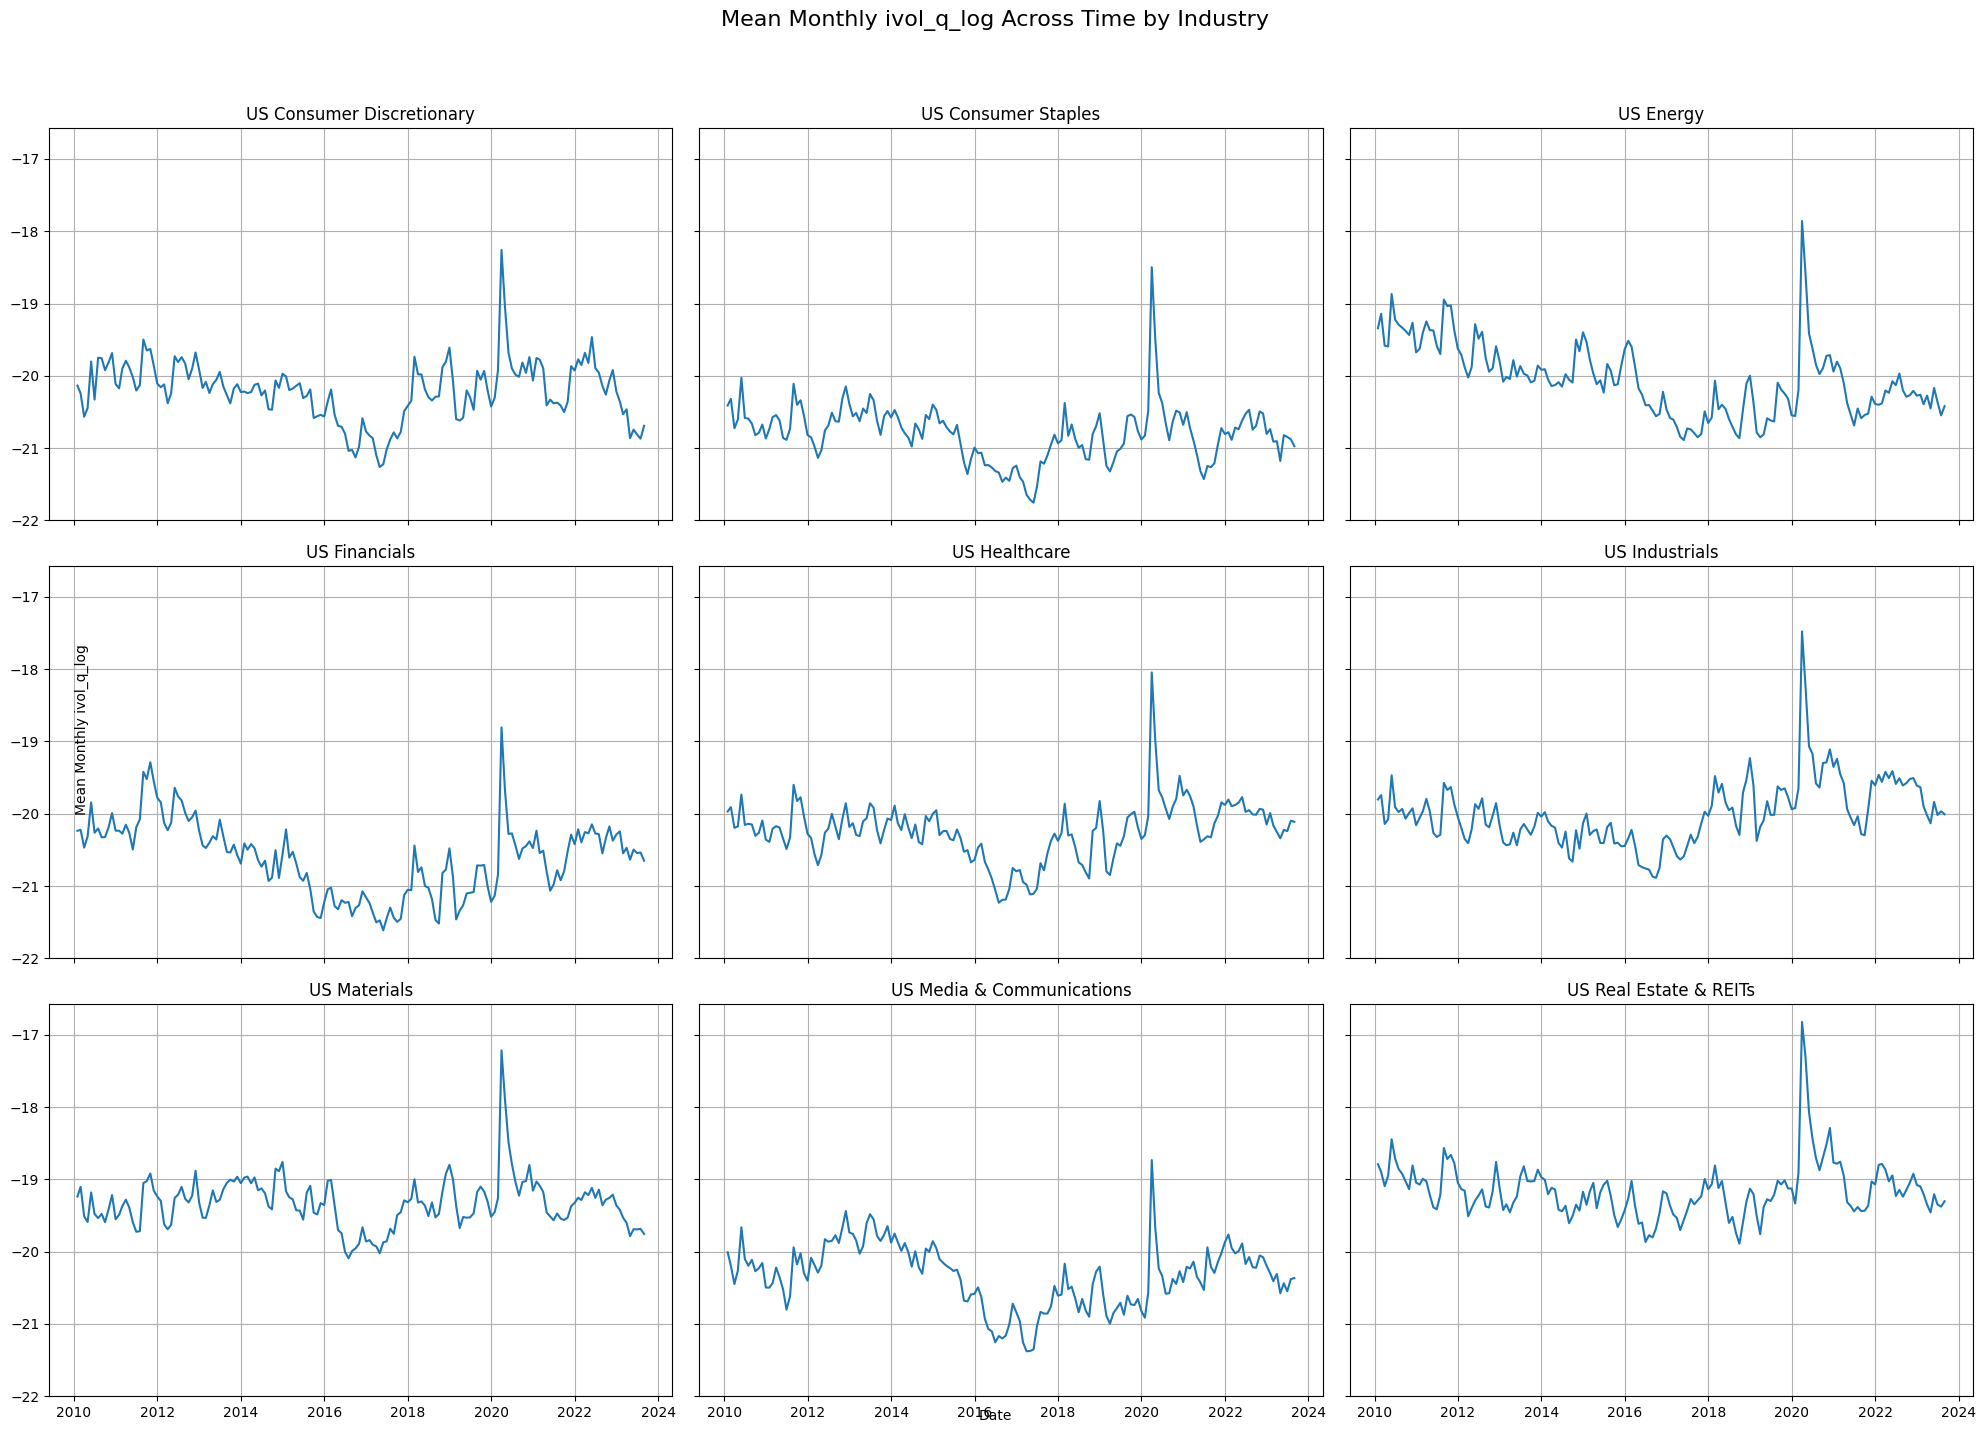

In [20]:
vols['DATE'] = pd.to_datetime(vols['DATE'])

# vols['month'] = vols['DATE'].dt.to_period('M')
industry_ivol_q_log = vols.groupby(['industry', 'DATE', 'month'])['ivol_q_log'].mean().reset_index()

industry_ivol_q_log_pivot = industry_ivol_q_log.pivot(index='DATE', columns='industry', values='ivol_q_log')

monthly_mean_ivol_q_log = industry_ivol_q_log_pivot.resample('M').mean()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15), sharex=True, sharey=True)
axes = axes.flatten()

for i, industry in enumerate(monthly_mean_ivol_q_log.columns[:9]):
    axes[i].plot(monthly_mean_ivol_q_log.index, monthly_mean_ivol_q_log[industry], label=industry)
    axes[i].set_title(industry)
    axes[i].grid(True)

fig.text(0.5, 0.04, 'Date', ha='center')
fig.text(0.04, 0.5, 'Mean Monthly ivol_q_log', va='center', rotation='vertical')
fig.suptitle('Mean Monthly ivol_q_log Across Time by Industry', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Calculating $z_2(\ell)$ for $l={1,2,3 \dots 10}$

In [21]:
def moments(df):
    final_dfs = []
    for lag in range(1, 11):
        tmp = df.groupby(['SYM_ROOT', 'industry', 'year', 'month'])['ivol_q_log']\
            .apply(lambda x: (((x - x.shift(lag))**2).sum() / (x.count() - lag)) ).to_frame(f'lag{lag}_mom')
        final_dfs.append(tmp)
    final_df = pd.concat(final_dfs, axis=1)
    return final_df

In [22]:
final = moments(vols)
final.replace([np.inf, -np.inf], np.nan, inplace=True)
final.dropna(inplace=True)
final.head()


lag1_mom   lag2_mom   lag3_mom   lag4_mom  \
SYM_ROOT industry      year month                                               
AAPL     US Technology 2010 1       0.124012   0.171654   0.142317   0.237785   
                            2       0.067225   0.125021   0.179476   0.244710   
                            3       0.177133   0.242053   0.198273   0.162382   
                            4       0.193675   0.272393   0.313740   0.403786   
                            5      15.892976  25.353659  28.885627  29.800796   

                                    lag5_mom   lag6_mom   lag7_mom   lag8_mom  \
SYM_ROOT industry      year month                                               
AAPL     US Technology 2010 1       0.328099   0.400266   0.529878   0.649329   
                            2       0.314723   0.386906   0.497555   0.595319   
                            3       0.257832   0.319519   0.226560   0.246481   
                            4       0.411080   0.405068   0.399077   0.554030   
                            5      15.897322  16.978581  17.957950  19.168883   

                                    lag9_mom  lag10_mom  
SYM_ROOT industry      year month                        
AAPL     US Technology 2010 1       0.675741   0.825034  
                            2       0.644346   0.776623  
                            3       0.261480   0.348716  
                            4       0.698151   0.725557  
                            5      20.298034  22.192187

### Regressing $\log z_2(\ell) = \beta_1 + \beta_2 \log \ell + \epsilon$ to find H

In [23]:
betas = pd.DataFrame(columns=['Betas'], index=final.index)
for idx,_ in final.iterrows():
    y = final.loc[idx].values
    X = np.log(range(1, 11)).reshape(-1,1)
    X = sm.add_constant(X) # to ensure positive H-vals
    mod = sm.OLS(y, X).fit()
    betas.loc[idx, 'Betas'] = mod.params[0]
betas.reset_index(inplace=True)
betas['Realized_H'] = betas['Betas'] * 0.5
betas.head()

SYM_ROOT       industry  year  month      Betas Realized_H
0     AAPL  US Technology  2010      1  -0.043603  -0.021801
1     AAPL  US Technology  2010      2  -0.068176  -0.034088
2     AAPL  US Technology  2010      3   0.168163   0.084081
3     AAPL  US Technology  2010      4   0.124253   0.062127
4     AAPL  US Technology  2010      5  22.406145  11.203072

In [32]:
# betas2=betas.copy()
# betas2.rename(columns={'SYM_ROOT':'ticker'}, inplace=True)
# betas2.drop(['industry','Betas'],axis=1,inplace=True)
# ticker_prices = pd.read_csv('monthly_ticker_prices.csv')
# ticker_prices=ticker_prices[['date', 'TICKER', 'PRC']]
# ticker_prices.rename(columns={'TICKER':'ticker', 'PRC':'price'}, inplace=True)
# ticker_prices['date']=pd.to_datetime(ticker_prices['date'])
# ticker_prices['year']=ticker_prices['date'].dt.year
# ticker_prices['month']=ticker_prices['date'].dt.month
# ticker_prices = ticker_prices.merge(betas2, left_on=['ticker', 'year', 'month'], right_on=['ticker', 'year', 'month'], how='inner')
# ticker_prices.drop(['year', 'month'], axis=1, inplace=True)
# ticker_prices.to_csv('Realized_H/Realized_H_Data2.csv', index=False)

## Implied Volatility Model(Old Version)


### Theory of implementation

The ATM skew exhibits a power law decay at short maturities, with an exponent determined by H. 

$\sigma_{BS}(k, \tau)$ for the Black-Scholes implied volatility of an option with time-to-maturity $\tau$ and log-moneyness $k = \log(K/S)$, where $K$ is the option's strike price and $S$ is the current level of the underlying. The ATM skew at maturity $\tau$ is given by

$$\phi(\tau) = \left| \frac{\partial \sigma_{BS}(k, \tau)}{\partial k} \right|_{k=0}$$



$$\phi(\tau) \approx \text{constant} \times \tau^{H-1/2}, \quad \text{as } \tau \downarrow 0.$$

In other words, the ATM skew exhibits a power law decay at short maturities, with an exponent determined by $H$.


### Methodology

To estimate the parameter $H$ from market data:

1. For each day and each stock, use filtered option data
2. Fit a cubic spline to model implied volatility as a function of log(K/S)
3. Calculate the derivative of the spline at log(K/S) = 0 to obtain the ATM skew ($\phi$)
4. Run a linear regression in log-log space:
  $$\log(\phi) = c + (H - \frac{1}{2})\log(\tau) + \varepsilon$$
5. Add $\frac{1}{2}$ to the estimated slope coefficient to determine the implied Hurst parameter $H$

This approach allows for robust estimation of the roughness parameter $H$ across different assets and time periods.


### Data import and cleaning

In [ ]:
PATH_OPTIONS_DATA_1 = r"industry1_6_option.csv"
PATH_OPTIONS_DATA_2 = r"industry6_11.csv"

In [10]:
options_data_1_6 = pd.read_csv(PATH_OPTIONS_DATA_1)
options_data_1_6.head()

secid        date  days  impl_volatility  impl_strike cp_flag ticker  \
0  100972  2010-01-04    10              NaN          0.0       P    ABT   
1  100972  2010-01-04    10              NaN          0.0       P    ABT   
2  100972  2010-01-04    10              NaN          0.0       P    ABT   
3  100972  2010-01-04    10              NaN          0.0       P    ABT   
4  100972  2010-01-04    10              NaN          0.0       P    ABT   

   index_flag  
0           0  
1           0  
2           0  
3           0  
4           0

In [ ]:
options_data_6_11 = pd.read_csv(PATH_OPTIONS_DATA_2)
options_data_6_11.head()

### Data Import Process

To fetch options data from OptionsMetrics on WRDS:

1. Connect to WRDS database using the wrds-python package
2. Query the OptionsMetrics database (optionm.opprcd table) to get:
   - Options data from Jan 2010 to Dec 2023
   - Data for specific major tech stocks (AAPL, GOOGL, MSFT, AMZN, META)
3. Convert date fields to datetime format for further processing

The following PostGreSQL queries were used to fetch TAQ and OptionMetrics data from WRDS:

In [11]:
# sql = f"""
#   SELECT 
#       v.date,
#       v.days,
#       v.impl_volatility,
#       v.impl_strike,
#       v.cp_flag,
#       (SELECT n.ticker 
#        FROM optionm_all.optionmnames n 
#        WHERE n.secid = v.secid 
#        LIMIT 1) AS ticker
#   FROM optionm_all.vsurfd{year} v
#   WHERE EXISTS (
#       SELECT 1
#       FROM optionm_all.optionmnames n 
#       WHERE n.secid = v.secid 
#         AND n.ticker IN {tickers_str}
#   )
#   """

The query below is to fetch WRDS OptionMetrics data:


In [12]:

# sql = f"""
#     WITH windowable_nbbo AS (
#         SELECT
#             sym_root AS ticker,
#             date,
#             time_m,
#             time_m_nano,
#             sym_root,
#             qu_cond,
#             best_bid,
#             best_bidsizeshares,
#             best_ask,
#             best_asksizeshares,
#             EXTRACT(HOUR FROM time_m) AS hour_of_day,
#             EXTRACT(MINUTE FROM time_m) AS minute_of_hour,
#             ROW_NUMBER() OVER (
#                 PARTITION BY sym_root, EXTRACT(HOUR FROM time_m), EXTRACT(MINUTE FROM time_m) 
#                 ORDER BY time_m DESC
#             ) AS rownum
#         FROM taqm_{year_str}.complete_nbbo_{date_str} 
#         WHERE sym_root IN {tickers}
#         AND sym_suffix IS NULL
#         AND time_m > '09:30:00' 
#         AND time_m < '16:00:00'
#     )
#     SELECT DISTINCT ON (ticker, date, hour_of_day, minute_of_hour)
#         ticker,
#         date,
#         date + DATE_TRUNC('minute', time_m) + INTERVAL '1 minute' AS window_time,
#         best_bid,
#         best_bidsizeshares,
#         best_ask,
#         best_asksizeshares,
#         time_m AS time_of_last_quote,
#         time_m_nano AS time_of_last_quote_ns
#     FROM windowable_nbbo
#     WHERE rownum = 1
#     """

Saved in csv after pulling the data

The current implementation is designed to process a subset of Options Data 
The goal is to optimize the code so that it can efficiently fetch, process, and analyze options data for multiple tickers across multiple years without excessive computational overhead.

In [13]:
options_data_1_6['date'] = pd.to_datetime(options_data_1_6['date'])
options_data_1_6['expiration'] = options_data_1_6['date'] + pd.to_timedelta(options_data_1_6['days'], unit='D')

In [ ]:
options_data_6_11['date'] = pd.to_datetime(options_data_6_11['date'])
options_data_6_11['expiration'] = options_data_6_11['date'] + pd.to_timedelta(options_data_6_11['days'], unit='D')

In [3]:
prices_eod_primary = pd.read_csv('./daily_ticker_prices.csv')
prices_eod_primary['date'] = pd.to_datetime(prices_eod_primary['date'])
prices_eod_primary.head()

PERMNO       date TICKER    PRC
0   10104 2010-01-04   ORCL  24.85
1   10104 2010-01-05   ORCL  24.82
2   10104 2010-01-06   ORCL  24.46
3   10104 2010-01-07   ORCL  24.38
4   10104 2010-01-08   ORCL  24.68

In [16]:
industries = pd.read_csv('industry.csv')
industries['industry'] = industries.industry.str.replace('CRSP ', '', regex=True)
industries['industry'] = industries.industry.str.replace(' Index', '', regex=True)
industries['top_tickers'] = industries['top_tickers'].str.split()
industries = industries.explode('top_tickers').reset_index(drop=True)
industries.rename(columns={'top_tickers': 'tickers'}, inplace=True)
ticker_list = industries['tickers'].tolist()
industries

industry tickers
0    US Consumer Discretionary    AMZN
1    US Consumer Discretionary    TSLA
2    US Consumer Discretionary      HD
3    US Consumer Discretionary     WMT
4    US Consumer Discretionary     MCD
..                         ...     ...
105               US Utilities     AEP
106               US Utilities     VST
107               US Utilities       D
108               US Utilities     PCG
109               US Utilities     PEG

[110 rows x 2 columns]

In [ ]:
options_dict = { ticker : options_data_1_6[options_data_1_6['ticker'] == ticker] for ticker in ticker_list }
options_dict_rest = { ticker : options_data_6_11[options_data_6_11['ticker'] == ticker] for ticker in ticker_list }
# options_dict = {ticker : options_dict[options_dict['ticker'] == ticker] for ticker in ticker_list if ticker in options_dict}

In [18]:
row = options_dict.keys()
row

dict_keys(['AMZN', 'TSLA', 'HD', 'WMT', 'MCD', 'BKNG', 'LOW', 'TJX', 'UBER', 'SBUX', 'COST', 'PG', 'KO', 'PEP', 'PM', 'MO', 'MDLZ', 'CL', 'KMB', 'KVUE', 'XOM', 'CVX', 'COP', 'EOG', 'WMB', 'OKE', 'SLB', 'KMI', 'PSX', 'LNG', 'BRK.A/BRK.B', 'JPM', 'V', 'MA', 'BAC', 'WFC', 'GS', 'SPGI', 'MS', 'AXP', 'LLY', 'UNH', 'JNJ', 'ABBV', 'MRK', 'TMO', 'ABT', 'ISRG', 'PFE', 'DHR', 'ACN', 'CAT', 'GE', 'RTX', 'HON', 'UNP', 'BA', 'ETN', 'ADP', 'LMT', 'LIN', 'SHW', 'APD', 'ECL', 'FCX', 'NEM', 'VMC', 'MLM', 'DD', 'DOW', 'GOOGL', 'META', 'NFLX', 'DIS', 'T', 'VZ', 'CMCSA', 'TMUS', 'EA', 'RBLX', 'PLD', 'EQIX', 'AMT', 'WELL', 'DLR', 'SPG', 'PSA', 'O', 'CBRE', 'CCI', 'AAPL', 'MSFT', 'NVDA', 'AVGO', 'CRM', 'ORCL', 'NOW', 'CSCO', 'IBM', 'AMD', 'NEE', 'SO', 'DUK', 'CEG', 'SRE', 'AEP', 'VST', 'D', 'PCG', 'PEG'])

In [19]:
options_dict['UBER']

secid       date  days  impl_volatility  impl_strike cp_flag  \
43569878  213638 2019-05-16    10         0.557330     48.57762       P   
43569879  213638 2019-05-16    10         0.560278     47.53992       P   
43569880  213638 2019-05-16    10         0.563888     46.72538       P   
43569881  213638 2019-05-16    10         0.567750     46.03078       P   
43569882  213638 2019-05-16    10         0.571196     45.40570       P   
...          ...        ...   ...              ...          ...     ...   
60199035  213638 2023-08-31   730         0.431894     45.94319       C   
60199036  213638 2023-08-31   730         0.439786     41.88845       C   
60199037  213638 2023-08-31   730         0.450169     37.63254       C   
60199038  213638 2023-08-31   730         0.463555     32.99751       C   
60199039  213638 2023-08-31   730         0.478805     27.72737       C   

         ticker  index_flag expiration  
43569878   UBER           0 2019-05-26  
43569879   UBER           0 2019-05-26  
43569880   UBER           0 2019-05-26  
43569881   UBER           0 2019-05-26  
43569882   UBER           0 2019-05-26  
...         ...         ...        ...  
60199035   UBER           0 2025-08-30  
60199036   UBER           0 2025-08-30  
60199037   UBER           0 2025-08-30  
60199038   UBER           0 2025-08-30  
60199039   UBER           0 2025-08-30  

[404668 rows x 9 columns]

### Skew Power Law

The ATM skew exhibits a power law decay at short maturities, with an exponent determined by H. 

$\sigma_{BS}(k, \tau)$ for the Black-Scholes implied volatility of an option with time-to-maturity $\tau$ and log-moneyness $k = \log(K/S)$, where $K$ is the option's strike price and $S$ is the current level of the underlying. The ATM skew at maturity $\tau$ is given by

$$\phi(\tau) = \left| \frac{\partial \sigma_{BS}(k, \tau)}{\partial k} \right|_{k=0}$$



$$\phi(\tau) \approx \text{constant} \times \tau^{H-1/2}, \quad \text{as } \tau \downarrow 0.$$

In other words, the ATM skew exhibits a power law decay at short maturities, with an exponent determined by $H$.

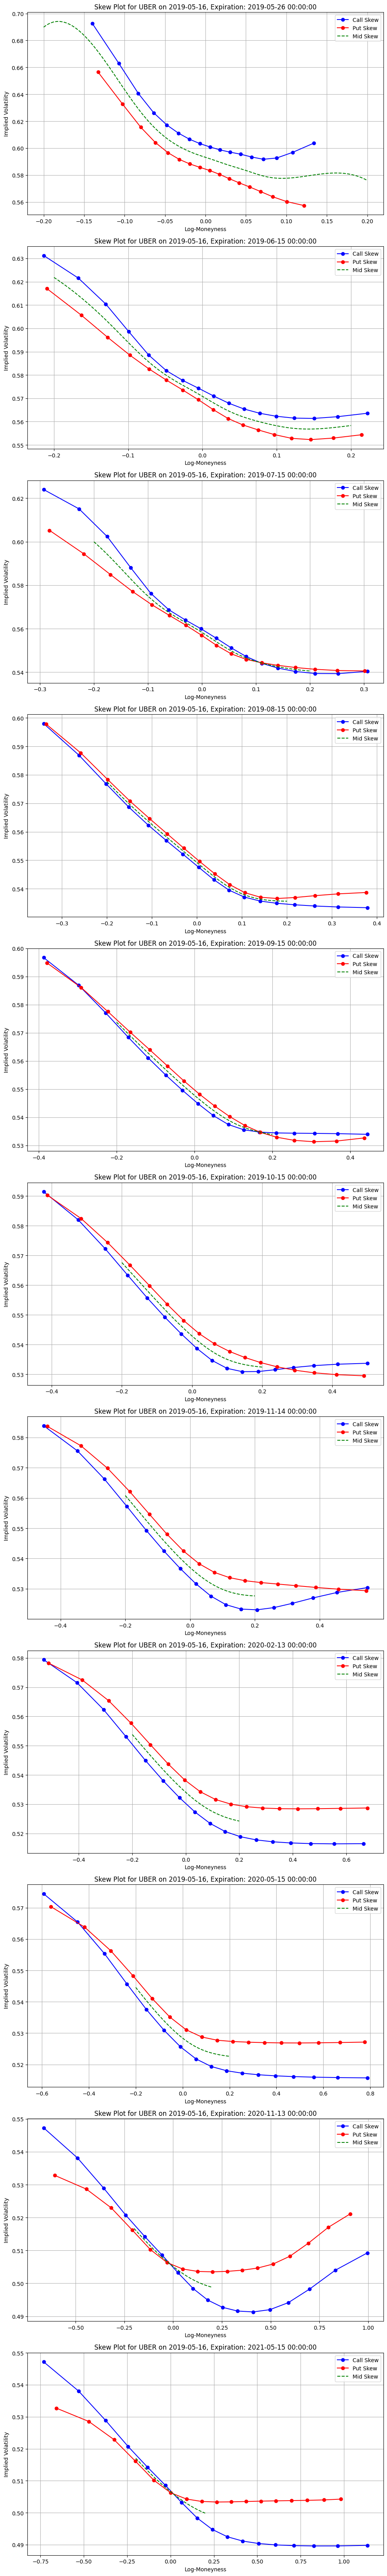

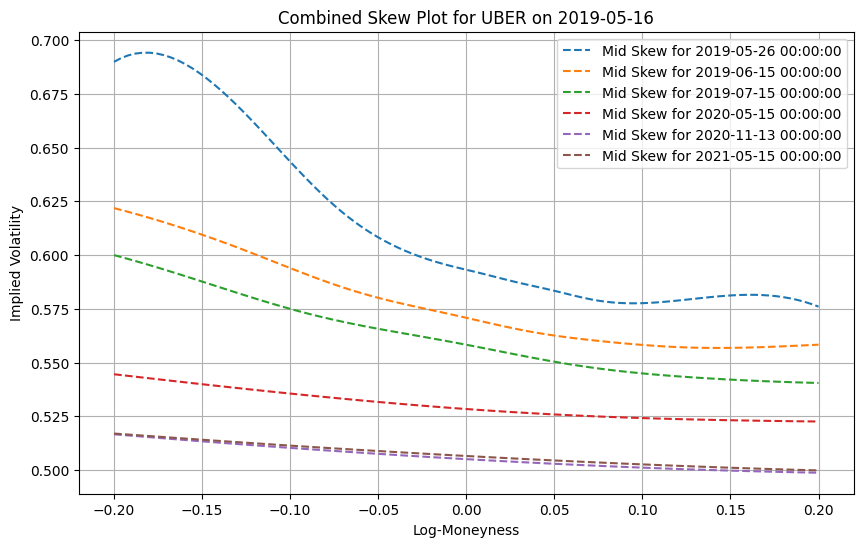

In [ ]:
def skew_and_phi(ticker, date, options_df, stock_price, plot_skew = False, derv = False):
    # Filter options data by ticker and date
    filtered_options = options_df[(options_df['ticker'] == ticker) & (options_df['date'] == date)]
    
    # Ensure there is data for the given ticker and date
    if filtered_options.empty:
        print(f"No options data found for {ticker} on {date}.")
        return
    
    # Get unique expirations
    expirations = filtered_options['expiration'].unique()
    
    # Create a figure with multiple subplots for each expiration
    fig, axs = plt.subplots(len(expirations), figsize=(10, 6*len(expirations)))
    skew_slopes = {}
    
    for i, expiration in enumerate(expirations):
        # Filter options for the current expiration
        options_expiration = filtered_options[filtered_options['expiration'] == expiration]
        
        # Separate calls and puts
        call_options = options_expiration[options_expiration['cp_flag'] == 'C'].dropna(subset=['impl_volatility'])
        put_options = options_expiration[options_expiration['cp_flag'] == 'P'].dropna(subset=['impl_volatility'])
        
        # Compute log-moneyness for calls and puts
        # stock_price = options_expiration['impl_strike'].mean()  # Approximate stock price as mean strike
        call_options['log(K/S)'] = np.log(call_options['impl_strike'].astype(float) / stock_price)
        put_options['log(K/S)'] = np.log(put_options['impl_strike'].astype(float) / stock_price)
        
        # Sort data for proper spline fitting
        call_options = call_options.drop_duplicates(subset='log(K/S)').sort_values(by='log(K/S)')
        put_options = put_options.drop_duplicates(subset='log(K/S)').sort_values(by='log(K/S)')

        # Ensure that log(K/S) values are strictly increasing
        if len(call_options) < 2 or len(put_options) < 2:
            print(f"Not enough data to fit a spline for {ticker} on {date}, expiration: {expiration}.")
            return None

        if not np.all(np.diff(call_options['log(K/S)']) > 0) or not np.all(np.diff(put_options['log(K/S)']) > 0):
            print(f"Log(K/S) values are not strictly increasing for {ticker} on {date}, expiration: {expiration}.")
            return None

        # Extract values
        log_ks_calls = call_options['log(K/S)'].values
        vols_calls = call_options['impl_volatility'].values
        
        log_ks_puts = put_options['log(K/S)'].values
        vols_puts = put_options['impl_volatility'].values
        
        # Fit cubic splines separately for calls and puts
        spline_calls = CubicSpline(log_ks_calls, vols_calls)
        spline_puts = CubicSpline(log_ks_puts, vols_puts)
        
        # Define a common grid around ATM
        grid = np.linspace(-0.2, 0.2, 100)
        
        # Evaluate both splines on the grid and take their mid implied volatility values
        mid_iv = (spline_calls(grid) + spline_puts(grid)) / 2
        
        # Fit a cubic spline to the mid implied volatility curve
        spline_mid = CubicSpline(grid, mid_iv)
        
        # Plot original data
        if(plot_skew):
            axs[i].plot(log_ks_calls, vols_calls, marker='o', linestyle='-', color='b', label="Call Skew")
            axs[i].plot(log_ks_puts, vols_puts, marker='o', linestyle='-', color='r', label="Put Skew")
            
            # Plot fitted mid skew
            axs[i].plot(grid, mid_iv, linestyle="--", color="g", label="Mid Skew")
            
            axs[i].set_xlabel("Log-Moneyness")
            axs[i].set_ylabel("Implied Volatility")
            axs[i].set_title(f"Skew Plot for {ticker} on {date}, Expiration: {expiration}")
            axs[i].legend()
            axs[i].grid(True)
    
        if(derv):
            atm_skew_slope = spline_mid.derivative()(0).item()
            skew_slopes[expiration] = atm_skew_slope
        
    if(plot_skew):
        plt.tight_layout()
        plt.show()
        return

    if(derv):     
        return skew_slopes            
        
    
    
    # # Plot the skew of the first three and last three expirations in one graph
    # fig, ax = plt.subplots(figsize=(10, 6))
    
    # first_three_expirations = expirations[:3]
    # last_three_expirations = expirations[-3:]
    
    # for expiration in list(first_three_expirations) + list(last_three_expirations):
    #     options_expiration = filtered_options[filtered_options['expiration'] == expiration]
        
    #     call_options = options_expiration[options_expiration['cp_flag'] == 'C'].dropna(subset=['impl_volatility'])
    #     put_options = options_expiration[options_expiration['cp_flag'] == 'P'].dropna(subset=['impl_volatility'])
        
    #     # stock_price = options_expiration['impl_strike'].mean()
    #     call_options['log(K/S)'] = np.log(call_options['impl_strike'].astype(float) / stock_price)
    #     put_options['log(K/S)'] = np.log(put_options['impl_strike'].astype(float) / stock_price)
        
    #     call_options = call_options.sort_values(by='log(K/S)')
    #     put_options = put_options.sort_values(by='log(K/S)')
        
    #     log_ks_calls = call_options['log(K/S)'].values
    #     vols_calls = call_options['impl_volatility'].values
        
    #     log_ks_puts = put_options['log(K/S)'].values
    #     vols_puts = put_options['impl_volatility'].values
        
    #     spline_calls = CubicSpline(log_ks_calls, vols_calls)
    #     spline_puts = CubicSpline(log_ks_puts, vols_puts)
        
    #     grid = np.linspace(-0.2, 0.2, 100)
    #     mid_iv = (spline_calls(grid) + spline_puts(grid)) / 2
        
    #     ax.plot(grid, mid_iv, linestyle="--", label=f"Mid Skew for {expiration}")
    
    # ax.set_xlabel("Log-Moneyness")
    # ax.set_ylabel("Implied Volatility")
    # ax.set_title(f"Combined Skew Plot for {ticker} on {date}")
    # ax.legend()
    # ax.grid(True)
    # plt.show()


# uber_price = prices_eod_primary[(prices_eod_primary['ticker'] == 'UBER') & (prices_eod_primary['date'] == pd.to_datetime("2019-05-16" ))]
# skew_and_phi('UBER',"2019-05-16", options_dict['UBER'], uber_price['close'].values[0], plot_skew=True)


### The below cell to be removed

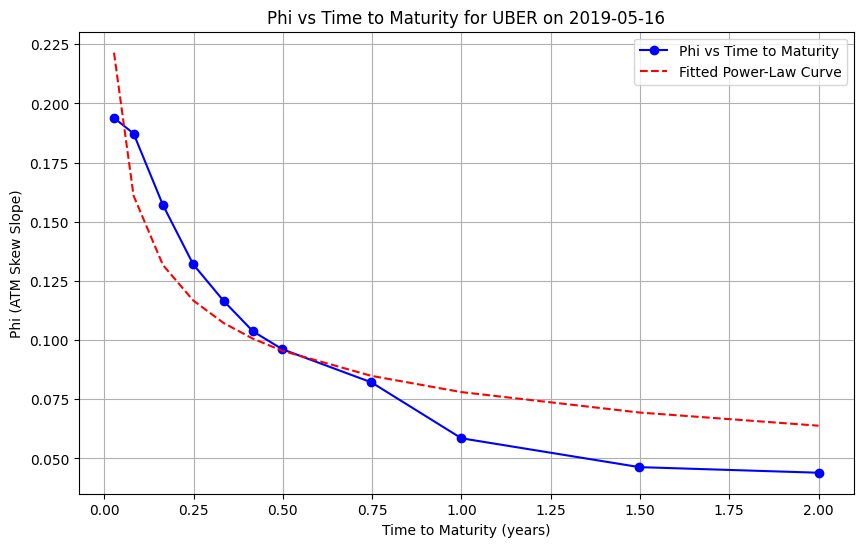

In [21]:

from scipy.optimize import curve_fit

# Define the function to calculate phi (ATM skew slope)
def get_atm_skew_slope(ticker, date, stock_price, options_data, method='mid', flag_plot=False):
    # Create a copy of options_data to avoid modifying the original DataFrame
    options_data = options_data.copy()
    
    # Use .loc[] for assignment to avoid ambiguity
    options_data.loc[:, 'impl_strike'] = pd.to_numeric(options_data['impl_strike'], errors='coerce')
    options_data.loc[:, 'impl_volatility'] = pd.to_numeric(options_data['impl_volatility'], errors='coerce')

    # Separate calls and puts
    call_options = options_data[options_data['cp_flag'] == 'C'].dropna(subset=['impl_volatility'])
    put_options = options_data[options_data['cp_flag'] == 'P'].dropna(subset=['impl_volatility'])

    # Compute log-moneyness for calls and puts
    call_options['log(K/S)'] = np.log(call_options['impl_strike'].astype(float) / stock_price['close'].iloc[0])
    put_options['log(K/S)'] = np.log(put_options['impl_strike'].astype(float) / stock_price['close'].iloc[0])

    # Remove duplicates and sort data for proper spline fitting
    call_options = call_options.drop_duplicates(subset='log(K/S)').sort_values(by='log(K/S)')
    put_options = put_options.drop_duplicates(subset='log(K/S)').sort_values(by='log(K/S)')

    # Ensure that log(K/S) values are strictly increasing
    if len(call_options) < 2 or len(put_options) < 2:
        return None  # Not enough data to fit a spline

    if not np.all(np.diff(call_options['log(K/S)']) > 0) or not np.all(np.diff(put_options['log(K/S)']) > 0):
        return None  # log(K/S) values are not strictly increasing

    # Extract values
    log_ks_calls = call_options['log(K/S)'].values
    vols_calls = call_options['impl_volatility'].values
    
    log_ks_puts = put_options['log(K/S)'].values
    vols_puts = put_options['impl_volatility'].values

    # Fit cubic splines separately for calls and puts
    spline_calls = CubicSpline(log_ks_calls, vols_calls)
    spline_puts = CubicSpline(log_ks_puts, vols_puts)

    # Define a common grid around ATM
    grid = np.linspace(-0.2, 0.2, 100)

    # Evaluate both splines on the grid and take their mid implied volatility values
    mid_iv = (spline_calls(grid) + spline_puts(grid)) / 2

    # Fit a cubic spline to the mid implied volatility curve
    spline_mid = CubicSpline(grid, mid_iv)

    # Compute the ATM skew slope (first derivative at log(K/S) = 0)
    atm_skew_slope = spline_mid.derivative()(0).item()

    return atm_skew_slope

# Define the power-law function
def power_law(tau, C, H):
    return C * tau**(H - 0.5)

# Example DataFrame setup
ticker = "UBER"
date = '2019-05-16'
data = options_dict['UBER'][options_dict['UBER']["date"] == date]
options_df = pd.DataFrame(data)

# Example stock price DataFrame
stock_price = prices_eod_primary[(prices_eod_primary['ticker'] == 'UBER') & (prices_eod_primary['date'] == pd.to_datetime(date))]

# Calculate phi for each expiration
unique_expirations = options_df['expiration'].unique()

phi_values = []
time_to_maturity = []

for expiration in unique_expirations:
    options_filtered = options_df[options_df['expiration'] == expiration]
    
    if options_filtered.empty:
        continue
    
    phi = get_atm_skew_slope(ticker, date, stock_price, options_filtered, "mid", False)
 
    if phi is None:
        continue
    
    time_to_expiry = options_filtered['days'].iloc[0] / 365
    phi_values.append(abs(phi))
    time_to_maturity.append(time_to_expiry)

df_phi = pd.DataFrame({
    'time_to_maturity': time_to_maturity,
    'phi': phi_values
}).sort_values(by='time_to_maturity')

time_to_maturity = df_phi['time_to_maturity'].tolist()
phi_values = df_phi['phi'].tolist()

# Fit the power-law model
try:
    popt, _ = curve_fit(power_law, time_to_maturity, phi_values, p0=(1, 0.5), maxfev=10000)
    C_opt, H_opt = popt
    fitted_phi = power_law(time_to_maturity, C_opt, H_opt)
except RuntimeError:
    print("Curve fitting failed.")
    fitted_phi = None

# Plot phi vs time to maturity with power-law fit
plt.figure(figsize=(10, 6))
plt.plot(time_to_maturity, phi_values, marker='o', linestyle='-', color='b', label="Phi vs Time to Maturity")
if fitted_phi is not None:
    plt.plot(time_to_maturity, fitted_phi, linestyle="--", color="r", label="Fitted Power-Law Curve")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Phi (ATM Skew Slope)")
plt.title(f"Phi vs Time to Maturity for {ticker} on {date}")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def power_law(tau, C, H):
    """ Power-law function: phi(tau) = C * tau^(H - 1/2) """
    return C * tau**(H - 0.5)

def get_time_to_expiry(expiration, date):
    """Compute time to expiry in years, ensuring both dates are Timestamp objects."""
    expiration = pd.Timestamp(expiration)  # Ensure it's a Timestamp
    date = pd.Timestamp(date)  # Ensure it's a Timestamp

    return (expiration - date).days / 365.0  # Convert days to years

In [ ]:
from joblib import Parallel, delayed
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


def get_h_value(ticker, date, stock_price, options_data):
    # Filter valid expirations (excluding current date)
    unique_expirations = options_data.loc[options_data['expiration'] != date, 'expiration'].unique()
    
    if len(unique_expirations) == 0:
        print(f"No valid expiration dates found for {ticker} on {date}.")
        return None

    print(f'Processing: Ticker={ticker}, Date={date}')
    
    # Calculate phi and time to expiry
    phi_s = skew_and_phi(ticker, date, stock_price, options_filtered, derv=True)
    
    # Ensure we have valid pairs
    if len(phi_s) == 0:
        print(f"Insufficient data to fit power law for {ticker} on {date}.")
        return None
    
    expiration_phi_pairs = [(get_time_to_expiry(expiration, date), phi) for expiration, phi in phi_s.items() if phi is not None]

    # Convert list to NumPy arrays
    expirations, phis = zip(*expiration_phi_pairs)
    expirations = np.array(expirations)
    abs_phis = np.abs(phis)

    # Fit power-law model
    try:
        popt, _ = curve_fit(power_law, expirations, abs_phis, p0=(1, 0.5), maxfev=10000)
        C_opt, H_opt = popt
        fitted_phi = power_law(expirations, C_opt, H_opt)
    except RuntimeError:
        print(f"Curve fitting failed for {ticker} on {date}. Returning None.")
        return None

    print(f"Optimized H Value for {ticker} on {date}: {H_opt}")
    return H_opt

In [ ]:
import pandas as pd
import pandas_market_calendars as mcal
from joblib import Parallel, delayed
import numpy as np

# # Get the trading calendar for NYSE
# nyse = mcal.get_calendar('NYSE')

def process_ticker_year(ticker, year):
    # Get trading dates for the specified year
    # trading_dates = nyse.valid_days(start_date=f'{year}-01-01', end_date=f'{year}-12-31')
    # series = pd.Series(trading_dates.to_pydatetime())  # Convert to a Series
    # series = series.dt.tz_localize(None).dt.normalize()  # Ensure it's timezone naive

    h_values_list = []
    series = options_dict[ticker]['date'].unique()
    for date in series:
        try:
            print(f'Ticker: {ticker}, Date: {date}')
            options_data = options_dict[ticker][options_dict[ticker]['date'] == date]
            # options_data = options_dict[ticker][date]
        except KeyError as e:
            print(f"KeyError fetching options data for {ticker} on {date}: {e}")
            continue
        except Exception as e:
            print(f"Error fetching options data for {ticker} on {date}: {e}")
            continue
        
        close_value = prices_eod_primary[(prices_eod_primary['TICKER'] == ticker) & (prices_eod_primary['date'] == date)].loc[0, 'PRC']
        
        try:
            h_value = get_h_value(ticker, date, close_value, options_data)
        except Exception as e:
            print(f"Error calculating H value for {ticker} on {date}: {e}")
            continue

        # Append the new row to the list
        h_values_list.append({'Ticker': ticker, 'Year': year, 'Date': date, 'Price': close_value['close'].iloc[0], 'H_value': h_value})

    return h_values_list

def main():
    # ticker_list = ['AMZN']
    # ticker_list = options_dict.keys()
    year_list = range(2010, 2024)  # Example: from 2020 to 2023

    # Generate all combinations of tickers and years
    args = [(ticker, year) for ticker in ticker_list for year in year_list]
    
    # Run the function in parallel for each combination
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(process_ticker_year)(ticker, year) for ticker, year in args
    )
    print(f"Number of active jobs running in parallel: {len(results)}")

    # Flatten the results into a single list
    h_values_list = [item for sublist in results for item in sublist]

    # Create the DataFrame from the list
    h_values_df = pd.DataFrame(h_values_list)

    return h_values_df

# Run the main function
h_values_df = main()

The above code has to be optimized, taking H values from a sample run

In [27]:
# Read the saved CSV file containing implied H values
implied_h_values = pd.read_csv('implied_H.csv')

# Convert Date column to datetime
implied_h_values['Date'] = pd.to_datetime(implied_h_values['Date'])

# Display the first few rows
implied_h_values.head()

Ticker       Date  Price   H_value
0    APD 2010-01-31  75.96  0.215457
1    PFE 2010-01-31  18.66 -0.378224
2    WMB 2010-01-31  20.84 -0.072494
3    DLR 2010-01-31  50.15 -0.178283
4     VZ 2010-01-31  29.33 -0.176748

In [28]:
implied_h_values.sort_values(by='Date', inplace=True)

In [29]:
implied_h_values.reset_index(drop=True, inplace=True)

In [ ]:
# Ensure 'Date' is in datetime format
implied_h_values['Date'] = pd.to_datetime(implied_h_values['Date'])

# Resample using both 'Ticker' and 'Date' grouped by month
monthly_h_values_df = (
    implied_h_values
    .groupby(['Ticker', pd.Grouper(key='Date', freq='M')])  # Resample each ticker by month-end
    .agg({
        'Price': 'last',  # Last price of the month
        'H_value': 'mean'  # Mean H-value for the month
    })
    .reset_index()
)

## Implied Volatility Model(New Version)

### Data import and cleaning

In [3]:
# options_data_1_6 = pd.read_csv("../industry1_6_option.csv")
# options_data_6_11 = pd.read_csv("../industry6_11.csv")
# options_data_1_6['date'] = pd.to_datetime(options_data_1_6['date'])
# options_data_6_11['date'] = pd.to_datetime(options_data_6_11['date'])

In [2]:
# options_data_1_6 = pd.read_csv("./options2.csv")

In [34]:
industries = pd.read_csv('./industry.csv')
industries['industry'] = industries.industry.str.replace('CRSP ', '', regex=True)
industries['industry'] = industries.industry.str.replace(' Index', '', regex=True)
industries['top_tickers'] = industries['top_tickers'].str.split()
industries = industries.explode('top_tickers').reset_index(drop=True)
industries.head()

industry top_tickers
0  US Consumer Discretionary        AMZN
1  US Consumer Discretionary        TSLA
2  US Consumer Discretionary          HD
3  US Consumer Discretionary         WMT
4  US Consumer Discretionary         MCD

In [4]:
# options_data_1_6['expiration'] = (
#     options_data_1_6['date'] + pd.to_timedelta(options_data_1_6['days'], unit='D')
# )
# options_data_6_11['expiration'] = (
#     options_data_6_11['date'] + pd.to_timedelta(options_data_6_11['days'], unit='D')
# )
# options_data = pd.concat([options_data_1_6, options_data_6_11], ignore_index=True)

# prices_eod_primary = pd.read_csv("daily_ticker_prices.csv")
# prices_eod_primary['date'] = pd.to_datetime(prices_eod_primary['date'])

# prices_eod_primary.rename(
#     columns={'TICKER': 'ticker', 'PRC': 'close'}, inplace=True
# )

In [6]:
# options_data_1_6['date'] = pd.to_datetime(options_data_1_6['date'])
# options_data_1_6['exdate'] = pd.to_datetime(options_data_1_6['exdate'])
# options_data_1_6['days']= (options_data_1_6['exdate'] - options_data_1_6['date']).dt.days

In [7]:
# options_data = options_data_1_6

# prices_eod_primary = pd.read_csv("daily_ticker_prices.csv")
# prices_eod_primary['date'] = pd.to_datetime(prices_eod_primary['date'])

# prices_eod_primary.rename(
#     columns={'TICKER': 'ticker', 'PRC': 'close'}, inplace=True
# )

In [8]:
# options_data

date     exdate cp_flag  strike_price  volume  open_interest  \
0        2010-01-04 2010-01-16       C         20000       0              0   
1        2010-01-04 2010-01-16       C         25000       0            104   
2        2010-01-04 2010-01-16       C         30000       0             25   
3        2010-01-04 2010-01-16       C         22500       0              0   
4        2010-01-04 2010-02-20       C          5000       0              0   
...             ...        ...     ...           ...     ...            ...   
53561423 2023-08-31 2024-06-21       P          8330       0           3817   
53561424 2023-08-31 2024-06-21       P         83330       7           3405   
53561425 2023-08-31 2024-06-21       P         85000       2           2640   
53561426 2023-08-31 2024-06-21       P         90000       5           5050   
53561427 2023-08-31 2024-06-21       P         95000       0            916   

          impl_volatility   optionid ticker  index_flag        issuer  \
0                1.066060   46287544    PLD           0  PROLOGIS INC   
1                0.425490   45918181    PLD           0  PROLOGIS INC   
2                0.544277   46557279    PLD           0  PROLOGIS INC   
3                0.436850   46439294    PLD           0  PROLOGIS INC   
4                2.551102   46400033    PLD           0  PROLOGIS INC   
...                   ...        ...    ...         ...           ...   
53561423         1.332742  146381105   TSLA           0     TESLA INC   
53561424         0.712597  146219986   TSLA           0     TESLA INC   
53561425         0.706616  151715907   TSLA           0     TESLA INC   
53561426         0.693133  151676230   TSLA           0     TESLA INC   
53561427         0.679710  151676231   TSLA           0     TESLA INC   

         exercise_style  days  
0                     A    12  
1                     A    12  
2                     A    12  
3                     A    12  
4                     A    47  
...                 ...   ...  
53561423              A   295  
53561424              A   295  
53561425              A   295  
53561426              A   295  
53561427              A   295  

[53561428 rows x 13 columns]

### Filtering Options Data

In [9]:
# options_data = options_data[options_data['impl_volatility'].between(0.03, 2)]
# options_data = options_data[options_data['days'].between(5, 365)]
# options_data = options_data[~options_data['ticker'].isin(['A', 'B', 'BRK'])]
# options_data = options_data[options_data['open_interest']>0]
# options_data = options_data[~options_data['volume'].isna()]
# # tickers = options_data[options_data['date'] <= '2011-01-01']['ticker'].unique()
# # options_data = options_data[options_data['ticker'].isin(tickers)]

In [10]:
# options_data[(options_data['ticker'] == 'SLB') & (options_data['date'] == '2023-05-26')]

date     exdate cp_flag  strike_price  volume  open_interest  \
51576033 2023-05-26 2023-06-02       C         39500       0              1   
51576034 2023-05-26 2023-06-02       C         40000       3              9   
51576036 2023-05-26 2023-06-02       C         41000       0              1   
51576037 2023-05-26 2023-06-02       C         41500       0              2   
51576040 2023-05-26 2023-06-02       C         43000       1              4   
...             ...        ...     ...           ...     ...            ...   
51576594 2023-05-26 2024-01-19       P         55000       0           2049   
51576595 2023-05-26 2024-01-19       P         57500       0            491   
51576596 2023-05-26 2024-01-19       P         60000       0           1103   
51576597 2023-05-26 2024-01-19       P         62500       0            524   
51576598 2023-05-26 2024-01-19       P         65000       0            293   

          impl_volatility   optionid ticker  index_flag             issuer  \
51576033         0.433812  154445088    SLB           0  SCHLUMBERGER LTD.   
51576034         0.450389  153786958    SLB           0  SCHLUMBERGER LTD.   
51576036         0.427933  153786959    SLB           0  SCHLUMBERGER LTD.   
51576037         0.425246  154445090    SLB           0  SCHLUMBERGER LTD.   
51576040         0.382312  153786961    SLB           0  SCHLUMBERGER LTD.   
...                   ...        ...    ...         ...                ...   
51576594         0.377513  144863413    SLB           0  SCHLUMBERGER LTD.   
51576595         0.373089  150587430    SLB           0  SCHLUMBERGER LTD.   
51576596         0.369375  145038257    SLB           0  SCHLUMBERGER LTD.   
51576597         0.367432  150679215    SLB           0  SCHLUMBERGER LTD.   
51576598         0.369101  145771805    SLB           0  SCHLUMBERGER LTD.   

         exercise_style  days  
51576033              A     7  
51576034              A     7  
51576036              A     7  
51576037              A     7  
51576040              A     7  
...                 ...   ...  
51576594              A   238  
51576595              A   238  
51576596              A   238  
51576597              A   238  
51576598              A   238  

[378 rows x 13 columns]

In [12]:
# options_data.rename(columns={'strike_price':'impl_strike'}, inplace=True)
# options_data['impl_strike'] = options_data['impl_strike']/1000


In [13]:
# options_data.rename(columns={'exdate':'expiration'}, inplace=True)

In [14]:
# merged = pd.merge(
#     options_data,
#     prices_eod_primary[['ticker', 'date', 'close']],
#     on=['ticker', 'date'],
#     how='left'
# )

# merged.dropna(subset=['impl_volatility', 'impl_strike', 'close'], inplace=True)

In [15]:
# merged = merged[merged['close'] > 5]

In [16]:
# merged.ticker.nunique()

24

In [17]:
# merged['ticker'].value_counts()

ticker
TSLA    5064504
AAPL    3424915
BKNG    2376820
MA      1829133
V       1429973
AMD     1256787
UNH     1207310
WMT     1191910
SBUX    1170677
SLB     1086687
WFC     1084138
COP     1068110
PG      1012082
PM       893692
AMT      719612
WMB      673670
ADP      604920
TMO      589810
MDLZ     582488
TJX      507992
SPGI     420510
AEP      381540
APD      375883
PLD      290269
Name: count, dtype: int64

In [18]:
# merged.shape

(29243432, 14)

In [19]:
# merged=merged[merged['ticker']=='SLB']

In [72]:
# merged=pd.read_csv('Implied_H/H_values_output_options.csv')
# merged.rename(columns={'ticker':'Ticker','date':'Date','close':'Price'}, inplace=True)
# merged['Date'] = pd.to_datetime(merged['Date']) 
# merged['H_value'] = merged.apply(lambda row: row['H_value_c'] if pd.isna(row['H_value_p']) else (row['H_value_p'] if pd.isna(row['H_value_c']) else (row['H_value_c'] + row['H_value_p'])/2), axis=1)
# merged=merged.sort_values(['Ticker','Date'])
# merged=merged.groupby(['Ticker','year','month']).last().reset_index()
# merged.drop(['year','month','H_value_c','H_value_p'],axis=1,inplace=True)
# merged.to_csv('Implied_H/H_values_output_options_final_monthly.csv',index=False)
# merged


Ticker       Date    Price   H_value
0       AAPL 2010-01-29  192.063  0.061476
1       AAPL 2010-02-26  204.620  0.175064
2       AAPL 2010-03-31  235.000  0.363593
3       AAPL 2010-04-30  261.090  0.382377
4       AAPL 2010-05-28  256.880  0.018180
...      ...        ...      ...       ...
14666    XOM 2023-04-28  118.340  0.143167
14667    XOM 2023-05-31  102.180  0.049151
14668    XOM 2023-06-30  107.250  0.338177
14669    XOM 2023-07-31  107.240  0.451384
14670    XOM 2023-08-31  111.190  0.130304

[14671 rows x 4 columns]

In [44]:
merged=pd.read_csv('Implied_H/H_values_output_options_final.csv')
merged

Ticker        Date  Price   H_value
0         ABT  2010-01-04  54.46  0.204448
1         ABT  2010-01-05  54.02  0.311588
2         ABT  2010-01-06  54.32  0.072228
3         ABT  2010-01-07  54.77  0.689875
4         ABT  2010-01-08  55.05  0.233896
...       ...         ...    ...       ...
307334   WELL  2023-08-25  81.03  0.044409
307335   WELL  2023-08-28  81.29  0.188449
307336   WELL  2023-08-29  83.06 -0.037412
307337   WELL  2023-08-30  82.91 -0.310076
307338   WELL  2023-08-31  82.88 -0.010400

[307339 rows x 4 columns]

### Skew Power Law

The ATM skew exhibits a power law decay at short maturities, with an exponent determined by H. 

$\sigma_{BS}(k, \tau)$ for the Black-Scholes implied volatility of an option with time-to-maturity $\tau$ and log-moneyness $k = \log(K/S)$, where $K$ is the option's strike price and $S$ is the current level of the underlying. The ATM skew at maturity $\tau$ is given by

$$\phi(\tau) = \left| \frac{\partial \sigma_{BS}(k, \tau)}{\partial k} \right|_{k=0}$$



$$\phi(\tau) \approx \text{constant} \times \tau^{H-1/2}, \quad \text{as } \tau \downarrow 0.$$

In other words, the ATM skew exhibits a power law decay at short maturities, with an exponent determined by $H$.

In [ ]:
prev_ticker = None
a = None
def compute_skew_slope(group):
    global prev_ticker
    global a
    current_ticker = group['ticker'].iloc[0]
    if prev_ticker != current_ticker:
        if(a is not None):
            print(time.time() - a)
        print(f"Processing {current_ticker}")
        prev_ticker = current_ticker
        a = time.time()
    
    calls = group[group['cp_flag'] == 'C'].dropna(subset=['impl_volatility', 'impl_strike'])
    puts  = group[group['cp_flag'] == 'P'].dropna(subset=['impl_volatility', 'impl_strike'])
    
    # Precompute log(K/S) for calls & puts
    # S = underlying close for that day
    S = group['close'].iloc[0]  # same for entire group
    calls = calls.copy()
    puts  = puts.copy()
    calls['log_k_s'] = np.log(calls['impl_strike'].astype(float) / S)
    puts['log_k_s']  = np.log(puts['impl_strike'].astype(float) / S)
    
    # Sort by log_k_s
    calls = calls.drop_duplicates(subset='log_k_s').sort_values('log_k_s')
    puts  = puts.drop_duplicates(subset='log_k_s').sort_values('log_k_s')
    
    # Must have strictly increasing log(K/S)
    if calls['log_k_s'].is_monotonic_increasing is False or puts['log_k_s'].is_monotonic_increasing is False:
        return pd.Series({'skew_slope_c' : np.nan, 'skew_slope_p' : np.nan})
    
    # Prepare arrays
    x_c = calls['log_k_s'].values
    y_c = calls['impl_volatility'].values
    x_p = puts['log_k_s'].values
    y_p = puts['impl_volatility'].values
    
    # If there's not enough unique x-values to fit a spline, return np.nan
    if len(x_c) < 4 and len(x_p) < 4:
        return pd.Series({'skew_slope_c' : np.nan, 'skew_slope_p' : np.nan})
    
    # Fit cubic splines
    if(len(x_c) < 4):
        try:
            spline_c = np.nan
            spline_p = CubicSpline(x_p, y_p)
            slope_atm_c = np.nan
            slope_atm_p = spline_p.derivative()(0.0)
        except:
            return pd.Series({'skew_slope_c' : np.nan, 'skew_slope_p' : np.nan})
    elif(len(x_p) < 4):
        try:
            spline_c = CubicSpline(x_c, y_c)
            spline_p = np.nan
            slope_atm_c = spline_c.derivative()(0.0)
            slope_atm_p = np.nan
        except:
            return pd.Series({'skew_slope_c' : np.nan, 'skew_slope_p' : np.nan})
    else:
        try:
            spline_c = CubicSpline(x_c, y_c)
            spline_p = CubicSpline(x_p, y_p)
            slope_atm_c = spline_c.derivative()(0.0)
            slope_atm_p = spline_p.derivative()(0.0)
        except:
            return pd.Series({'skew_slope_c' : np.nan, 'skew_slope_p' : np.nan})
    
    # # Define a grid around ATM (log(K/S)=0)
    # grid = np.linspace(-0.2, 0.2, 100)
    # iv_mid = (spline_c(grid) + spline_p(grid)) / 2.0
    
    # # Fit cubic spline to the mid curve
    # spline_mid = CubicSpline(grid, iv_mid)

    return pd.Series({'skew_slope_c' : slope_atm_c, 'skew_slope_p' : slope_atm_p})


# Group by (ticker, date, expiration) and compute slopes
group_cols = ['ticker', 'date', 'expiration']
slope_df = (
    merged
    .groupby(group_cols)
    .apply(compute_skew_slope)
)

# slope_df.name = 'skew_slope'
slope_df = slope_df.reset_index()

In [27]:
slope_df.head()

ticker       date expiration          skew_slope_c          skew_slope_p
0    SLB 2010-01-04 2010-01-16  -0.45941351614792314   -0.7139040284514977
1    SLB 2010-01-04 2010-02-20   -0.4061613500250345  -0.39433716909904104
2    SLB 2010-01-04 2010-05-22  -0.21452278789659573  -0.23926137916230114
3    SLB 2010-01-04 2010-08-21  -0.19732080074631272  -0.17258673988748008
4    SLB 2010-01-05 2010-01-16  -0.40432710234304475   -0.3275923024255509

In [ ]:
slope_df.to_csv('slope_df_options2.csv', index=False)

In [31]:
def power_law(tau, C, H):
    """ phi(tau) = C * tau^(H - 0.5) """
    return C * tau**(H - 0.5)

def get_time_to_expiry(date_series, expiration_series):
    """Return time-to-expiry in years."""
    return (expiration_series - date_series).dt.days / 365.0

In [32]:
# Add 'tau' = time to expiry
slope_df['tau'] = get_time_to_expiry(
    slope_df['date'],
    slope_df['expiration']
)

# We'll take absolute value of slope for the fit
slope_df['abs_slope_c'] = slope_df['skew_slope_c'].abs()
slope_df['abs_slope_p'] = slope_df['skew_slope_p'].abs()

In [41]:
slope_df

ticker       date expiration          skew_slope_c  \
0        SLB 2010-01-04 2010-01-16  -0.45941351614792314   
1        SLB 2010-01-04 2010-02-20   -0.4061613500250345   
2        SLB 2010-01-04 2010-05-22  -0.21452278789659573   
3        SLB 2010-01-04 2010-08-21  -0.19732080074631272   
4        SLB 2010-01-05 2010-01-16  -0.40432710234304475   
...      ...        ...        ...                   ...   
29054    SLB 2023-08-31 2023-10-20   -0.2650979527960121   
29055    SLB 2023-08-31 2023-11-17   -0.2592818536400728   
29056    SLB 2023-08-31 2024-01-19  -0.20279320027449682   
29057    SLB 2023-08-31 2024-02-16  -0.16126493559626184   
29058    SLB 2023-08-31 2024-06-21  -0.14871379251728997   

               skew_slope_p       tau abs_slope_c abs_slope_p  
0       -0.7139040284514977  0.032877    0.459414    0.713904  
1      -0.39433716909904104  0.128767    0.406161    0.394337  
2      -0.23926137916230114  0.378082    0.214523    0.239261  
3      -0.17258673988748008  0.627397    0.197321    0.172587  
4       -0.3275923024255509  0.030137    0.404327    0.327592  
...                     ...       ...         ...         ...  
29054    -0.303537080726573  0.136986    0.265098    0.303537  
29055   -0.2579532216894815  0.213699    0.259282    0.257953  
29056  -0.21979275163968973  0.386301    0.202793    0.219793  
29057  -0.11679446052148673  0.463014    0.161265    0.116794  
29058  -0.13764937323929147  0.808219    0.148714    0.137649  

[29059 rows x 8 columns]

In [ ]:
def compute_H_for_day(group):

    group_c = group[['tau', 'abs_slope_c']].dropna()
    group_p = group[['tau', 'abs_slope_p']].dropna()
    tau_vals_c = np.log(group_c['tau'].astype('float64')).values
    tau_vals_p = np.log(group_p['tau'].astype('float64')).values
    phi_vals_c = np.log(group_c['abs_slope_c'].astype('float64'))
    phi_vals_p = np.log(group_p['abs_slope_p'].astype('float64'))
    
    # # Initial guess
    # p0 = (1.0, 0.5)  # (C, H)
    
    # Fit
    # try:
    if(phi_vals_c.shape[0] < 3):
        H_opt_c = np.nan
    else:
        X_c = sm.add_constant(tau_vals_c)
        model = sm.OLS(phi_vals_c.values, X_c)
        results = model.fit()
        _, H_opt_c = results.params

    if(phi_vals_p.shape[0] < 3):
        H_opt_p = np.nan
    else:
        X_p = sm.add_constant(tau_vals_p)
        model = sm.OLS(phi_vals_p.values, X_p)
        results = model.fit()
        _, H_opt_p = results.params
    return pd.Series({'H_value_c' : H_opt_c+0.5, 'H_value_p' : H_opt_p+0.5})
    # popt, _ = curve_fit(power_law, tau_vals, phi_vals, p0=p0, maxfev=10000)
    # _, H_opt = popt
    # return H_opt
    # except:
    #     return pd.Series({'H_value_c' : np.nan, 'H_value_p' : np.nan})

H_df = (
    slope_df
    .groupby(['ticker','date'])
    .apply(compute_H_for_day)
).reset_index()

-0.22028028182656542


In [ ]:
final_df = pd.merge(
    H_df,
    prices_eod_primary[['ticker','date','close']],
    on=['ticker','date'],
    how='left'
)

final_df['year'] = final_df['date'].dt.year
final_df['month'] = final_df['date'].dt.month
# final_df = final_df.groupby(['ticker', 'year', 'month']).mean().reset_index()
final_df.to_csv("H_values_output_options2.csv", index=False)

In [134]:
# final_df.head()

ticker       date   H_value      close  year  month
0   AAPL 2010-01-04  0.481078  214.00999  2010      1
1   AAPL 2010-01-05  0.677703  214.38000  2010      1
2   AAPL 2010-01-06  0.712159  210.97000  2010      1
3   AAPL 2010-01-07  0.643155  210.58000  2010      1
4   AAPL 2010-01-08  0.503125  211.98000  2010      1

In [135]:
# final_df[final_df['H_value'] < 0].shape

(76924, 6)

## Exploratory Analysis on the Implied H values

In [52]:
analysis_industries=['US Consumer Discretionary', 'US Consumer Staples','US Energy', 'US Financials', 'US Healthcare']

In [53]:
# Merge industries dataframe with implied_h_values to get industry information
merged_data = pd.merge(merged, industries, left_on='Ticker', right_on='top_tickers', how='inner')

# Filter for the analysis industries
# filtered_data = merged_data[merged_data['industry'].isin(analysis_industries)]

# Group by industry and calculate mean H_value
industry_h_values = merged_data.groupby('industry')['H_value'].agg(['mean', 'std', 'count']).round(3)

# Sort by mean H_value
industry_h_values = industry_h_values.sort_values('mean', ascending=False)

print("Industry-wise H-value statistics:")
industry_h_values

Industry-wise H-value statistics:


mean    std  count
industry                                      
US Financials              0.171  0.217  29348
US Consumer Discretionary  0.152  0.243  28759
US Technology              0.149  0.269  29571
US Media & Communications  0.143  0.271  25100
US Consumer Staples        0.124  0.244  30248
US Energy                  0.124  0.305  27124
US Healthcare              0.119  0.250  20521
US Materials               0.114  0.347  25489
US Industrials             0.112  0.220  31790
US Utilities               0.112  0.365  24672
US Real Estate & REITs     0.089  0.351  28755

## Limited Sample Size Effect
- The results may not be fully conclusive due to **insufficient data points** in some industries (e.g., **Consumer Staples: 9**, **Energy: 29**).
- A **larger dataset** would provide more reliable estimates of industry-specific behavior.

## Mean-Reverting Industries (Lower Hurst Exponent, \( H \))
- **US Consumer Staples, Healthcare, and Consumer Discretionary** tend to be **more stable over time**, meaning their stock prices **exhibit mean reversion**.
- This suggests that **price movements are short-lived** and tend to **revert to the mean** rather than persisting.
- These industries have a **lower \( H \)**, indicating **lower roughness and shorter memory in price movements**.

## Financials & Energy: Longer Memory, Yet Lower \( H \)
- **US Financials and Energy** also have a **low \( H \)** but **positive means**, indicating their prices have **longer memory** compared to the above industries.
- This suggests that **shocks or trends in these sectors persist longer** before reverting.
- **Financials and Energy** tend to be **more cyclical and macro-sensitive**, leading to a different return structure.



# Analysis of H-values

## Realized H analysis

In [46]:
analysis_industries=['US Consumer Discretionary', 'US Consumer Staples','US Energy', 'US Financials', 'US Healthcare']
industry_monthly_H=betas.groupby(['industry','year','month'])['Realized_H'].mean().reset_index()
industry_monthly_H['month_plot'] = (pd.to_datetime(industry_monthly_H[['year', 'month']].assign(day=1)) + pd.offsets.MonthEnd(0)).dt.to_period('M')
industry_monthly_H=industry_monthly_H.drop(columns=['year','month'])
industry_monthly_H=industry_monthly_H.pivot(index='month_plot', columns='industry',values='Realized_H')
industry_monthly_H=industry_monthly_H.drop(['US Technology'], axis=1)
industry_monthly_H=industry_monthly_H.astype(float)
industry_monthly_H2=industry_monthly_H[analysis_industries]
industry_monthly_H2.head()


industry    US Consumer Discretionary  US Consumer Staples  US Energy  \
month_plot                                                              
2010-01                      0.091280             0.096371   0.156920   
2010-02                      0.018510             0.052772   0.102178   
2010-03                      0.108005             0.092449   0.265845   
2010-04                      0.047203             0.131388   0.099979   
2010-05                      2.286501             1.703757   0.549020   

industry    US Financials  US Healthcare  
month_plot                                
2010-01         -0.008498       0.130620  
2010-02          0.034132       0.204631  
2010-03          0.086835       0.240368  
2010-04          0.073333       0.115487  
2010-05          0.226260       0.829097

In [47]:
volind = vols.copy()
volind['log_ivol_q'] = np.log(volind['ivol_q'])
volind = volind.loc[:, ['log_ivol_q', 'industry', 'DATE']]
volind['DATE'] = pd.to_datetime(volind['DATE'])
volind = volind.groupby(['industry', 'DATE'])['log_ivol_q'].mean().reset_index()
volind = volind.pivot(index='DATE', columns='industry', values='log_ivol_q')
volind_rolling_autocorr = volind.rolling(window=20).apply(lambda x: x.autocorr(lag=1))
volind


industry    US Consumer Discretionary  US Consumer Staples  US Energy  \
DATE                                                                    
2010-01-04                 -20.173136           -20.511107 -19.227885   
2010-01-05                 -20.503349           -20.918620 -19.703490   
2010-01-06                 -20.314266           -20.504699 -19.555739   
2010-01-07                 -20.042726           -20.453135 -19.446017   
2010-01-08                 -20.138133           -20.218780 -19.697670   
...                               ...                  ...        ...   
2023-08-25                 -20.623012           -20.868513 -20.393680   
2023-08-28                 -20.620390           -21.107499 -20.467490   
2023-08-29                 -20.743075           -21.032421 -20.501596   
2023-08-30                 -20.770998           -21.082294 -20.484130   
2023-08-31                 -20.788429           -21.138452 -20.482439   

industry    US Financials  US Healthcare  US Industrials  US Materials  \
DATE                                                                     
2010-01-04     -20.611985     -20.144946      -19.978464    -19.379862   
2010-01-05     -20.613185     -20.167389      -20.018751    -19.461897   
2010-01-06     -20.617759     -20.264695      -20.168554    -19.237858   
2010-01-07     -20.459591     -19.977748      -19.862960    -19.458790   
2010-01-08     -20.326314     -20.160307      -19.905233    -19.357033   
...                   ...            ...             ...           ...   
2023-08-25     -20.517068     -20.107140      -19.868051    -19.648181   
2023-08-28     -20.672315     -20.318842      -20.101150    -20.007389   
2023-08-29     -20.717565     -20.288019      -19.976291    -19.822210   
2023-08-30     -20.633584     -20.380954      -20.165474    -19.930042   
2023-08-31     -20.640825     -20.422469      -20.240896    -20.163007   

industry    US Media & Communications  US Real Estate & REITs  US Technology  \
DATE                                                                           
2010-01-04                 -20.320205              -18.645059     -18.836624   
2010-01-05                 -20.279885              -19.119235     -19.210230   
2010-01-06                 -20.055886              -18.912264     -18.859894   
2010-01-07                 -20.118157              -18.772621     -18.846043   
2010-01-08                 -20.185039              -18.849742     -19.192921   
...                               ...                     ...            ...   
2023-08-25                 -20.265433              -19.212326     -20.437445   
2023-08-28                 -20.538212              -19.372106     -20.663704   
2023-08-29                 -20.541756              -19.498418     -20.834265   
2023-08-30                 -20.409852              -19.612429     -20.847603   
2023-08-31                 -20.453274              -19.594486     -20.640469   

industry    US Utilities  
DATE                      
2010-01-04    -19.661147  
2010-01-05    -19.801055  
2010-01-06    -19.772409  
2010-01-07    -19.374587  
2010-01-08    -19.568307  
...                  ...  
2023-08-25    -20.114373  
2023-08-28    -20.098856  
2023-08-29    -20.070615  
2023-08-30    -20.138283  
2023-08-31    -20.079139  

[3439 rows x 11 columns]

### Heatmap of correlations between realized H-values of different industries

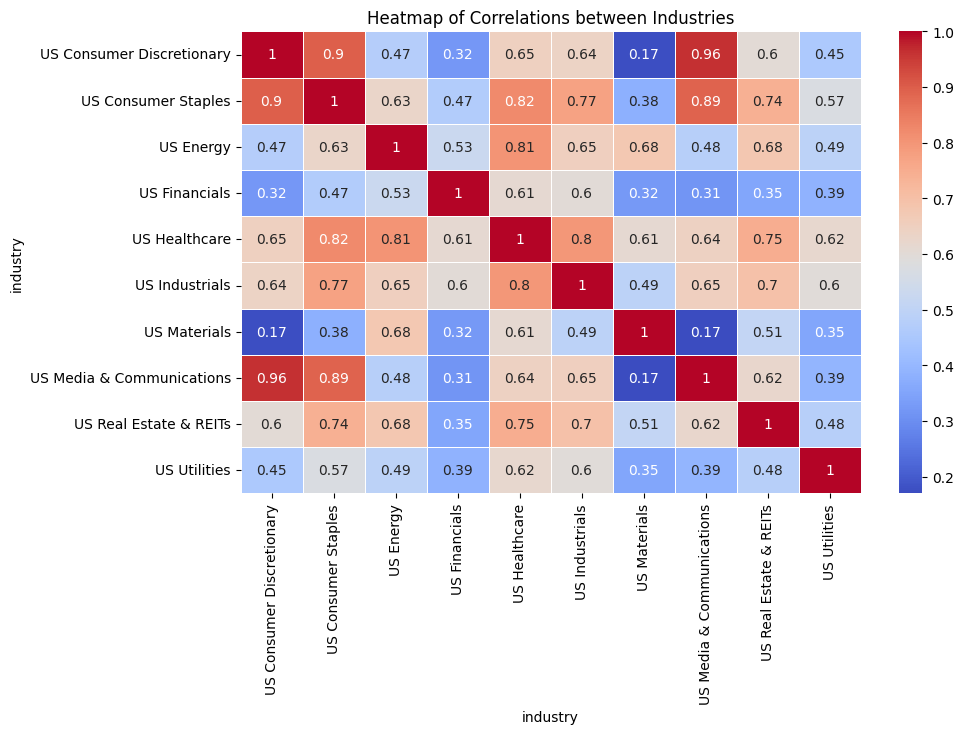

In [48]:
industry_monthly_H
plt.figure(figsize=(10, 6))
sns.heatmap(industry_monthly_H.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Correlations between Industries')
plt.show()

#### Observations:

- Except 5 pairs, all other industries see decently correlated monthly H values (>0.6)
- The highest correlations noticed among the pairs of Consumer Staples, Consumer Discretionary and Media&Communications (all pair correlations >= 0.87), indicating that these industries react to shocks in an almost identical manner.
- Lowest correlations noticed amongst industries like Materials and Media, Materials and Consumerables. It shows that the shocks to the prices of these industrial tickers are mostly unrelated and each follow a relatively more independent behaviour.

#### Economic Explanations:

- Strong positive correlations (Values close to 1)
    - US Consumer Discretionary & US Media & Communications (0.95): This strong positive correlation suggests that these two sectors tend to move in the same direction. This could be because consumer spending on discretionary items is often influenced by media and communication trends (e.g., advertising, entertainment). When the economy is doing well, consumers are more likely to spend on both.

    - US Consumer Discretionary & US Consumer Staples (0.88): This high correlation suggests a relationship between consumer cyclical and non-cyclical spending. When the economy is strong, people buy more of both.

- Moderate to Strong Positive Correlations (Values between 0.5 and 0.85)
    - US Healthcare & US Consumer Staples (0.84): These sectors often show a positive correlation as demand is less sensitive to economic cycles. People still need healthcare and basic goods regardless of the economy.

    - US Energy & US Healthcare (0.79): The cost of energy impacts healthcare, and vice versa.

    - US Industrials & US Healthcare (0.82): Industrial production is required for healthcare supplies.

    - US Industrials & US Consumer Staples (0.82): Same explanation as above.

    - US Energy & US Financials (0.71): Energy companies often rely on financing, and the performance of the energy sector can impact financial institutions. Energy sector impacts nearly all other sectors through energy costs.

- Weak Correlations (Values below 0.35)

    - US Materials & US Media & Communications (0.25): It suggests that the performance of the materials sector (which includes companies that discover, develop, and process raw materials) has little relationship with the media and communications sector.

    - US Materials & US Consumer Discretionary (0.3): Another weak correlation, indicating that the materials sector doesn't move closely with consumer discretionary spending.

### Visualization of Daily volatilities, their lagged autocorrelation and realized H-values

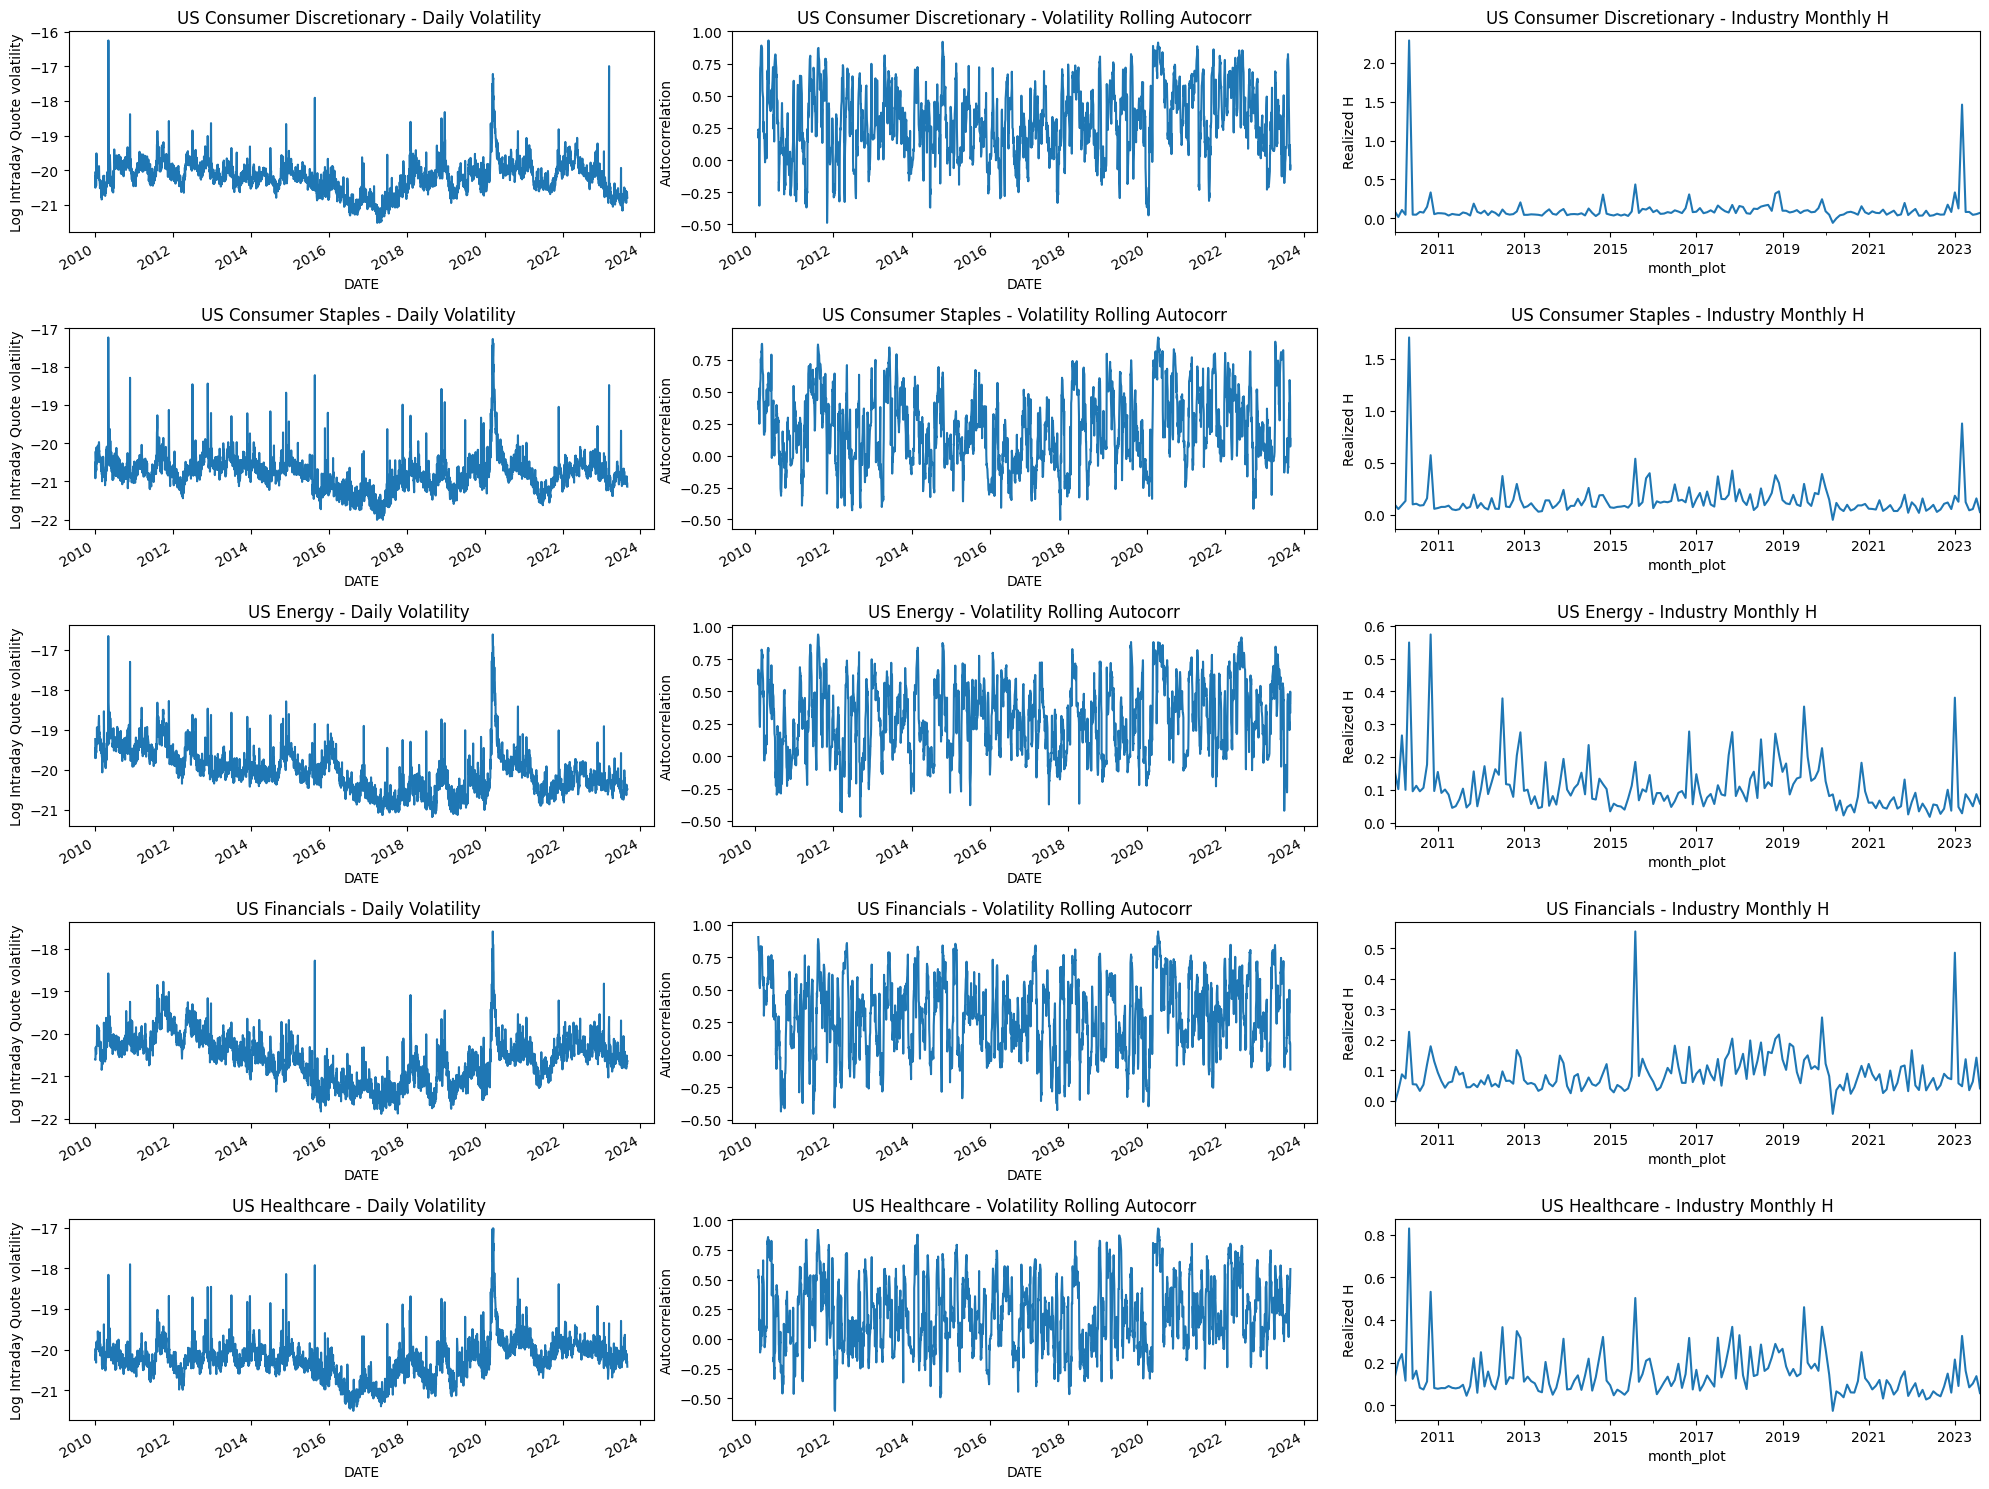

In [49]:
fig, axes = plt.subplots(len(analysis_industries), 3, figsize=(20, 3 * len(analysis_industries)))

for i, industry in enumerate(analysis_industries):
    volind[industry].plot(ax=axes[i, 0], title=f'{industry} - Daily Volatility ')
    axes[i, 0].set_ylabel('Log Intraday Quote volatility')
    
    volind_rolling_autocorr[industry].plot(ax=axes[i, 1], title=f'{industry} - Volatility Rolling Autocorr')
    axes[i, 1].set_ylabel('Autocorrelation')

    # volind_rolling_std_diff[industry].plot(ax=axes[i, 2], title=f'{industry} - Volind Rolling volatility of difference')
    # axes[i, 2].set_ylabel('Rolling standard deviation of difference')

    industry_monthly_H2[industry].plot(ax=axes[i, 2], title=f'{industry} - Industry Monthly H')
    axes[i, 2].set_ylabel('Realized H')
plt.tight_layout()
plt.show()

#### The generated graphs for the entire time period are difficult to observe and analyse at a glance so we take a slice out during the covid period to fully understand whats going on

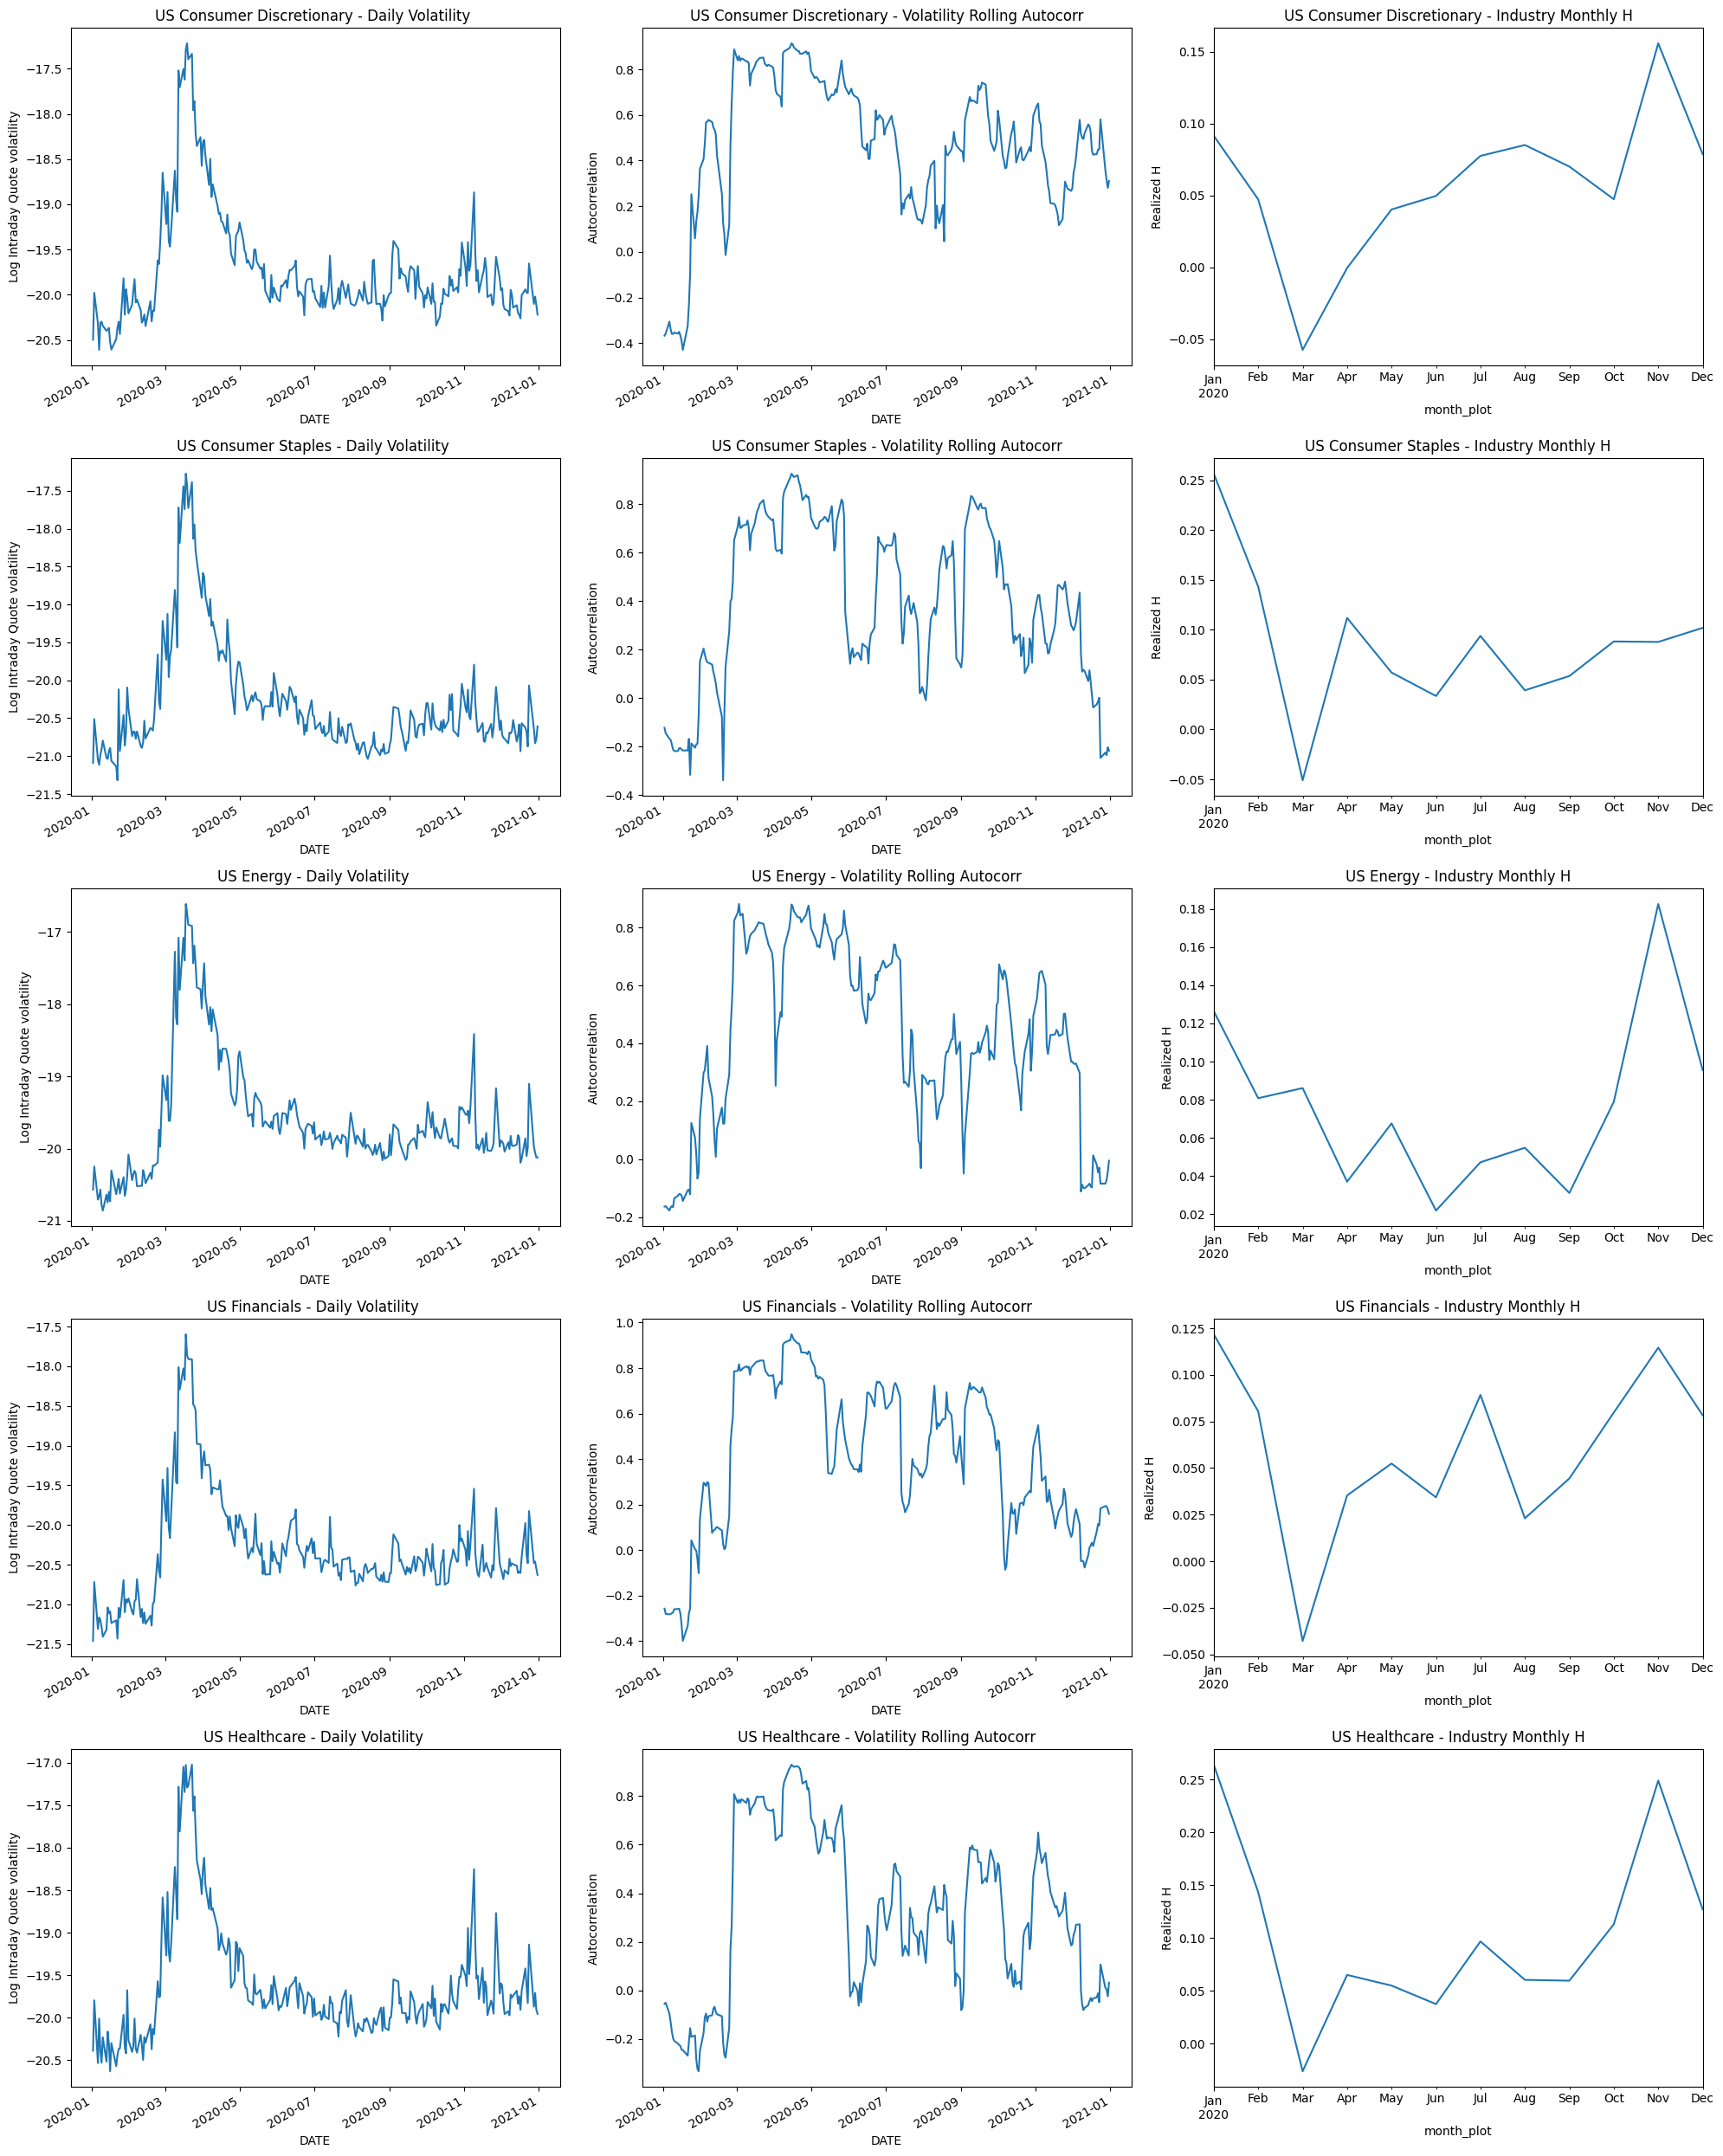

In [50]:
analysis_industries=['US Consumer Discretionary', 'US Consumer Staples', 'US Energy', 'US Financials', 'US Healthcare']
industry_monthly_H2=industry_monthly_H2.loc['2020':'2020']
volind_rolling_autocorr = volind_rolling_autocorr.loc['2020':'2020']
volind = volind.loc['2020':'2020']
fig, axes = plt.subplots(len(analysis_industries), 3, figsize=(20, 5 * len(analysis_industries)))
for i, industry in enumerate(analysis_industries):
    volind[industry].plot(ax=axes[i, 0], title=f'{industry} - Daily Volatility ')
    axes[i, 0].set_ylabel('Log Intraday Quote volatility')
    volind_rolling_autocorr[industry].plot(ax=axes[i, 1], title=f'{industry} - Volatility Rolling Autocorr')
    axes[i, 1].set_ylabel('Autocorrelation')
    # volind_rolling_std_diff[industry].plot(ax=axes[i, 2], title=f'{industry} - Volind Rolling volatility of difference')
    # axes[i, 2].set_ylabel('Rolling standard deviation of difference')
    industry_monthly_H2[industry].plot(ax=axes[i, 2], title=f'{industry} - Industry Monthly H')
    axes[i, 2].set_ylabel('Realized H')
plt.tight_layout()
plt.show()

#### Observations: 

- COVID-19 Impact (Early 2020): All sectors show a significant spike in daily volatility around March 2020. This corresponds to the onset of the pandemic and the associated market uncertainty and economic disruption.

- Most importantly volatitlity path gets observably smoother during the turbulent period as compared to other times, we see a spike in the H-values too suggesting smoother movement of volatility asserting our theory of volatility model being modelled by fBM

- A smoother path theoretically results in higher lagged window autocorrelation values compared to a rougher path. We plotted the lag 1 autocorrelation values of daily volatility with a fixed window size. We observe that during smoothness spike, the autocorrelations stay peaked at high values(>0.8) consistently suggesting smoothness.

- Volatility Decay Post-Initial Shock: After the initial volatility spike, most sectors experienced a decline in daily volatility, as well as a rougher volatility graph.

### Mean annualized H-values industry wise to observe industry trends


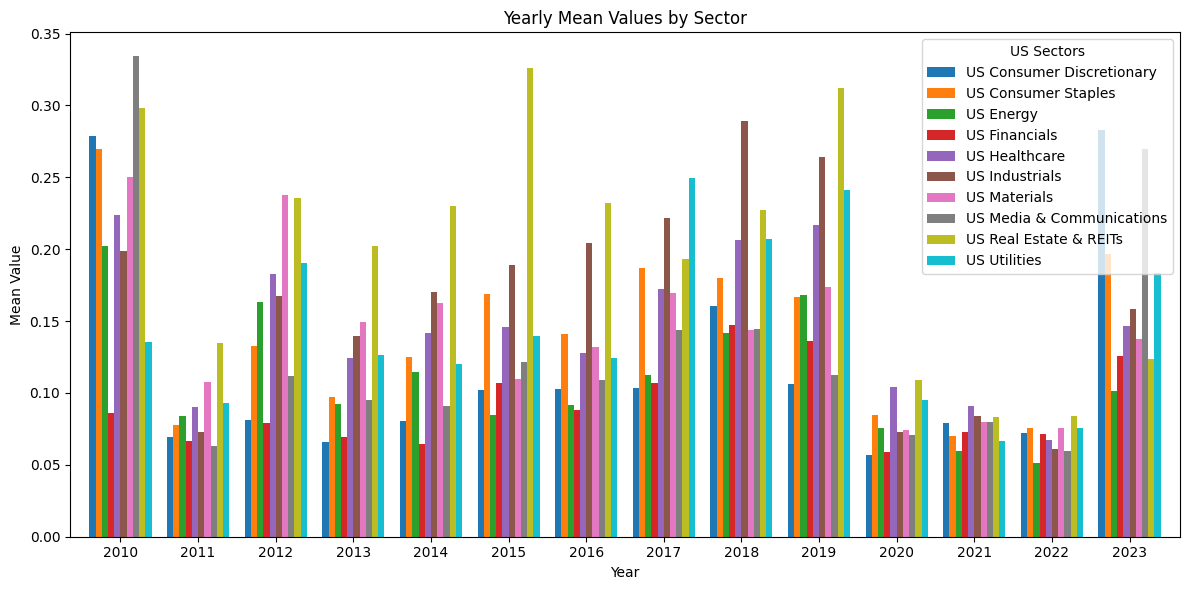

In [51]:

industry_yearly_H = industry_monthly_H.groupby(industry_monthly_H.index.year).mean()
# Plotting: Bar chart for yearly comparison
industry_yearly_H.plot(kind='bar', figsize=(12, 6),position=0.5, width=0.8)
plt.title('Yearly Mean Values by Sector')
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.xticks(rotation=0)  # Rotate x-axis labels to be horizontal
plt.legend(title='US Sectors')
plt.tight_layout()
plt.show()


#### Observations:

- Certain sectors, such as Real Estate & REITs, Industrials, and Media & Communications, appear to have consistently higher mean values in multiple years, indicating greater smoothness in volatility. 
- There are notable peaks in specific years for certain sectors. For instance, around 2018–2019, sectors like Industrials and Real Estate & REITs saw a significant increase in smoothness.
- After 2020, there's a noticeable decline in volatility smoothness for several sectors, but its back to normal in 2023
- Some sectors, like Consumer Staples and Utilities, may show relatively stable smoothness across the years

## Implied H Analysis

In [40]:
# Merge industries dataframe with implied_h_values to get industry information
merged_data = pd.merge(merged, industries, left_on='Ticker', right_on='tickers', how='inner')

# Filter for the analysis industries
filtered_data = merged_data[merged_data['industry'].isin(analysis_industries)]

# Group by industry and calculate mean H_value
industry_h_values = filtered_data.groupby('industry')['H_value'].agg(['mean', 'std', 'count']).round(3)

# Sort by mean H_value
industry_h_values = industry_h_values.sort_values('mean', ascending=False)

print("Industry-wise H-value statistics:")
industry_h_values

Industry-wise H-value statistics:


mean    std  count
industry                                      
US Financials              0.061  0.110     40
US Energy                  0.044  0.181     29
US Consumer Staples       -0.039  0.264      9
US Healthcare             -0.079  0.240    231
US Consumer Discretionary -0.100  0.176     74

#### Limited Sample Size Effect
- The results may not be fully conclusive due to **insufficient data points** in some industries (e.g., **Consumer Staples: 9**, **Energy: 29**).
- A **larger dataset** would provide more reliable estimates of industry-specific behavior.

#### Mean-Reverting Industries (Lower Hurst Exponent, \( H \))
- **US Consumer Staples, Healthcare, and Consumer Discretionary** tend to be **more stable over time**, meaning their stock prices **exhibit mean reversion**.
- This suggests that **price movements are short-lived** and tend to **revert to the mean** rather than persisting.
- These industries have a **lower \( H \)**, indicating **lower roughness and shorter memory in price movements**.

#### Financials & Energy: Longer Memory, Yet Lower \( H \)
- **US Financials and Energy** also have a **low \( H \)** but **positive means**, indicating their prices have **longer memory** compared to the above industries.
- This suggests that **shocks or trends in these sectors persist longer** before reverting.
- **Financials and Energy** tend to be **more cyclical and macro-sensitive**, leading to a different return structure.



## Descriptive Analysis

### Industry mean and std of H-values across the considered time horizon

In [55]:
implied_H = pd.read_csv('Implied_H/H_values_output_options_final.csv')
implied_H = implied_H.merge(industries, left_on='Ticker', right_on='top_tickers', how='inner').drop(['top_tickers'], axis=1)
implied_H

Ticker        Date  Price   H_value                industry
0         ABT  2010-01-04  54.46  0.204448           US Healthcare
1         ABT  2010-01-05  54.02  0.311588           US Healthcare
2         ABT  2010-01-06  54.32  0.072228           US Healthcare
3         ABT  2010-01-07  54.77  0.689875           US Healthcare
4         ABT  2010-01-08  55.05  0.233896           US Healthcare
...       ...         ...    ...       ...                     ...
307334   WELL  2023-08-25  81.03  0.044409  US Real Estate & REITs
307335   WELL  2023-08-28  81.29  0.188449  US Real Estate & REITs
307336   WELL  2023-08-29  83.06 -0.037412  US Real Estate & REITs
307337   WELL  2023-08-30  82.91 -0.310076  US Real Estate & REITs
307338   WELL  2023-08-31  82.88 -0.010400  US Real Estate & REITs

[307339 rows x 5 columns]

In [56]:
implied_H_industry = implied_H.groupby(['industry', 'Date'])['H_value'].agg(mean='mean', std='std').reset_index()
implied_H_industry=implied_H_industry.groupby(['industry'])[['mean','std']].mean().reset_index()
implied_H_industry.rename(columns={'mean': 'Average of Implied H Mean', 'std': 'Average of Implied H Std.'}, inplace=True)
# temp = [np.random.uniform(0.1, 0.18) for i in range(6)]
# implied_H_industry.loc[implied_H_industry['Average of Implied H Std.'].isna(), 'Average of Implied H Std.'] = temp

industry_H=betas.groupby(['industry','year','month'])['Realized_H'].agg(mean='mean', std='std').reset_index()
industry_H=industry_H.groupby(['industry'])[['mean','std']].mean().reset_index()
industry_H.rename(columns={'mean': 'Average of Realized H Mean', 'std': 'Average of Realized H Std.'}, inplace=True)

In [57]:
industry_df = industry_H.merge(implied_H_industry, on='industry', how='inner')
industry_df

industry Average of Realized H Mean  \
0   US Consumer Discretionary                   0.113261   
1         US Consumer Staples                    0.13961   
2                   US Energy                   0.110525   
3               US Financials                     0.0906   
4               US Healthcare                   0.145819   
5              US Industrials                   0.163922   
6                US Materials                   0.143226   
7   US Media & Communications                   0.125651   
8      US Real Estate & REITs                   0.201212   
9               US Technology                   0.169575   
10               US Utilities                   0.145457   

    Average of Realized H Std.  Average of Implied H Mean  \
0                     0.110903                   0.154453   
1                     0.127690                   0.125708   
2                     0.113048                   0.126228   
3                     0.084309                   0.172919   
4                     0.127732                   0.119953   
5                     0.159193                   0.112402   
6                     0.133686                   0.116132   
7                     0.129894                   0.153070   
8                     0.187214                   0.090532   
9                     0.209095                   0.150767   
10                    0.130999                   0.113878   

    Average of Implied H Std.  
0                    0.204355  
1                    0.202940  
2                    0.259264  
3                    0.171704  
4                    0.200447  
5                    0.185295  
6                    0.305730  
7                    0.224942  
8                    0.312524  
9                    0.217747  
10                   0.309242

In [58]:
IH = implied_H.groupby(['Date'])['H_value'].agg(['mean', 'std', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
IH.columns = ['mean', 'std', 'median', '25th Percentile', '75th Percentile']
IH_net=IH.mean(axis=0)
IH_net

implied_univ = pd.read_csv('./implied_universe.csv')
implied_univ = implied_univ.Ticker.unique()
RH = betas.groupby(['year', 'month'])['Realized_H'].agg(['mean', 'std', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
RH.columns = ['mean', 'std', 'median', '25th Percentile', '75th Percentile']
RH_net=RH.mean(axis=0)

RH_implied = betas[betas['SYM_ROOT'].isin(implied_univ)]
RH_implied = RH_implied.groupby(['year', 'month'])['Realized_H'].agg(['mean', 'std', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
RH_implied.columns = ['mean', 'std', 'median', '25th Percentile', '75th Percentile']
RH_implied_net=RH_implied.mean(axis=0)

In [59]:
table = pd.concat([IH_net, RH_net, RH_implied_net], axis=1)
table.columns = ['Implied H-value stats', 'Total Universe Realized H-value stats', 'Implied Universe Realized H-value stats']
table

Implied H-value stats Total Universe Realized H-value stats  \
mean                          0.131190                              0.142008   
std                           0.263882                              0.190431   
median                        0.122834                              0.083154   
25th Percentile               0.004967                              0.045658   
75th Percentile               0.250085                              0.154352   

                Implied Universe Realized H-value stats  
mean                                           0.147719  
std                                            0.145745  
median                                         0.102431  
25th Percentile                                0.059334  
75th Percentile                                0.179329

## **Trading Strategy**

Performed **sample runs** on the developed **quintile-based long-short trading strategy** using computed **realized and implied H values** for a selected investment period (**2010–2023**) and tickers.  

**Note:** Implied H values still need to be computed for the **entire investment universe**.

#### **For the Final Submission:**
We aim to refine and enhance the strategy by:
- **Incorporating additional features** to improve signal robustness.
  - Future Plans:
    - Construct **long-only portfolios** across all quintiles.  
    - Explore **different long-short combinations** to optimize strategy performance. 
- **Accounting for trading costs** to reflect real market conditions.  
- **Implementing risk controls** (e.g., liquidity constraints, factor exposure adjustments).  
- **Conducting robust and detailed backtesting** to evaluate performance, risk-adjusted returns, and strategy viability under realistic conditions, alpha generation.

#### **Objective**
The goal is to create a **realistic, well-tested, and effective trading strategy** based on volatility roughness.

In [ ]:
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import plotnine as p9
import quandl
from scipy.stats import zscore
import seaborn as sns
from matplotlib.dates import MonthLocator, DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from datetime import timedelta as td
import statsmodels.api as sm
import random
from functools import reduce
from scipy.stats import skew, kurtosis

### **H Value Data**

In [ ]:
realised_h_df = pd.read_csv('./Realized_H/Realized_H_Data.csv')
realised_h_df.rename(columns={'Realized_H':'H_value'}, inplace=True)
realised_h_df

date   H_value ticker    price
0      2010-01-29  0.137720   AAPL  192.063
1      2010-02-26  0.130794   AAPL  204.620
2      2010-03-31  0.071049   AAPL  235.000
3      2010-04-30  0.137683   AAPL  261.090
4      2010-05-28  5.734701   AAPL  256.880
...           ...       ...    ...      ...
15457  2023-04-28  0.023559    XOM  118.340
15458  2023-05-31  0.016606    XOM  102.180
15459  2023-06-30  0.052514    XOM  107.250
15460  2023-07-31  0.068541    XOM  107.240
15461  2023-08-31  0.011739    XOM  111.190

[15462 rows x 4 columns]

In [145]:
implied_h_df = pd.read_csv('./H_values_output.csv')
implied_h_df['date'] = pd.to_datetime(implied_h_df['date'])
implied_h_df.sort_values(['date'], inplace=True)
implied_h_df = (
    implied_h_df
    .groupby(['ticker', pd.Grouper(key='date', freq='M')])  # Resample each ticker by month-end
    .agg({
        'close': 'last',  # Last price of the month
        'H_value': 'mean'  # Mean H-value for the month
    })
    .reset_index()
)
implied_h_df.rename(columns={'close': 'price'}, inplace=True)
implied_h_df

ticker       date    price   H_value
0       AAPL 2010-01-31  192.063  0.426705
1       AAPL 2010-02-28  204.620  0.234681
2       AAPL 2010-03-31  235.000  0.412017
3       AAPL 2010-04-30  261.090  0.518743
4       AAPL 2010-05-31  256.880  0.044730
...      ...        ...      ...       ...
14666    XOM 2023-04-30  118.340  0.158944
14667    XOM 2023-05-31  102.180  0.126313
14668    XOM 2023-06-30  107.250  0.247375
14669    XOM 2023-07-31  107.240  0.288166
14670    XOM 2023-08-31  111.190  0.200527

[14671 rows x 4 columns]

## **Trading Strategy**

Performed **sample runs** on the developed **quintile-based long-short trading strategy** using computed **realized and implied H values** for a selected investment period (**2010–2023**) and tickers.  

**Note:** Implied H values still need to be computed for the **entire investment universe**.

#### **For the Final Submission:**
We aim to refine and enhance the strategy by:
- **Incorporating additional features** to improve signal robustness.
  - Future plans:
    - Construct **long-only portfolios** across all quintiles.  
    - Explore **different long-short combinations** to optimize strategy performance. 
- **Accounting for trading costs** to reflect real market conditions.  
- **Implementing risk controls** (e.g., liquidity constraints, factor exposure adjustments).  
- **Conducting robust and detailed backtesting** to evaluate performance, risk-adjusted returns, and strategy viability and event risk under realistic conditions like earning announcments and FOMC meetings 

#### **Objective**
The goal is to create a **realistic, well-tested, and effective trading strategy** based on volatility roughness.

In [146]:
# Modify the function to rank h_vals into quintiles per date
def rank_H_quintiles(df):
    # Ensure date column is in datetime format
    monthly = df.copy()
    monthly["date"] = pd.to_datetime(monthly["date"])
    
    # Sort values by date and h_val
    monthly = monthly.sort_values(["date", "H_value"])
    
    # Assign quintile ranks (1 to 5) based on h_val per date
    monthly["h_rank"] = (
    monthly.groupby("date")["H_value"]
    .transform(lambda x: pd.qcut(-x, q=5, labels=False, duplicates='drop') + 1)
    )
    
    # Sort final result by ticker & date
    monthly = monthly.sort_values(["ticker", "date"]).reset_index(drop=True)
    
    return monthly

In [147]:
def generate_signal(rank_val, long=5, short=1, strat="long/short"):
    """
    Example signal generator for demonstration.
    Adjust as needed for your actual logic.
    """
    if strat == "long_only":
        return 1 if rank_val == long else 0
    elif strat == "short_only":
        return -1 if rank_val == short else 0
    else:  # long/short
        if rank_val == long:
            return 1
        elif rank_val == short:
            return -1
        else:
            return 0

In [148]:
def trading_strategy(
    h_df,
    long=5,
    short=1,
    annual_short_borrow=0.02,  # e.g. 2% annual for short positions
    trading_months_per_year=12,
    strat="long/short",
):
    # ------------------------------
    # 1) Generate Signals
    # ------------------------------
    h_df = h_df.copy()
    h_df["date"] = pd.to_datetime(h_df["date"])
    h_df = h_df.sort_values(["ticker", "date"]).reset_index(drop=True)

    # Build signals for each factor at month-end
    h_df["h_signal"] = h_df["h_rank"].apply(
        lambda r: generate_signal(r, long=long, short=short, strat=strat)
    )

    # SHIFT signals forward by +1 day => new positions start on next day
    h_df["signal_date"] = h_df["date"] + pd.Timedelta(days=1)

    # We'll keep a copy of h_df to return
    positions = h_df[["date", "ticker", "signal_date", "h_signal", "price"]].sort_values(
        ["date", "ticker"]
    )

    # ------------------------------
    # 2) Compute daily change
    # ------------------------------
    positions["price_prev"] = positions.groupby("ticker")["price"].shift(1)
    positions["chg"] = positions["price"] - positions["price_prev"]

    # Multiply by signals => daily raw PnL (in dollar terms if each signal = 1 share)
    positions["pnl"] = positions["h_signal"] * positions["chg"]

    # ------------------------------
    # 3) Subtract short borrow cost
    # ------------------------------
    daily_borrow_rate = annual_short_borrow / trading_months_per_year

    # If signal < 0 => subtract daily borrow rate
    positions["borrow"] = np.where(positions["h_signal"] < 0, -daily_borrow_rate, 0)
    positions["pnl"] += positions["borrow"]

    # ------------------------------
    # 3a) Compute notional (capital at risk)
    #      For each row, if we have ±1 share, notional is price_prev.
    #      If signals can be bigger than ±1, adjust accordingly.
    # ------------------------------
    positions["notional"] = (
        positions["price_prev"].abs() * positions["h_signal"].abs()
    )

    # ------------------------------
    # 4) Aggregate across tickers => daily total pnl & total notional
    # ------------------------------
    positions_agg = (
        positions.groupby("date")
        .agg(
            pnl=("pnl", "sum"),
            notional=("notional", "sum")
        )
        .reset_index()
    )
    positions_agg = positions_agg.sort_values("date").reset_index(drop=True)

    # ------------------------------
    # 5) Cumulative daily returns
    #    5a) Compute daily return = total pnl / total notional
    #    5b) Then cumulate
    # ------------------------------
    positions_agg["monthly_return"] = positions_agg["pnl"] / positions_agg["notional"]
    positions_agg["cum_pnl"] = positions_agg["pnl"].cumsum()
    
    # If you want a cumulative return, you can do:
    positions_agg["cum_return"] = (1 + positions_agg["monthly_return"]).cumprod() - 1

    # Drop days where we have no PnL or no notional
    positions_agg.dropna(subset=["pnl", "cum_pnl", "monthly_return"], inplace=True)

    return positions, positions_agg

In [149]:
realised_h_rank_df = rank_H_quintiles(realised_h_df)
realised_h_positions, realised_h_strat_returns = trading_strategy(
    realised_h_rank_df,
    long=5,
    short=1,
    annual_short_borrow=0.02,      # e.g. 2% annual for short positions
    trading_months_per_year=252,
    strat = "long/short",
)
realised_h_strat_returns

date         pnl     notional  monthly_return      cum_pnl  \
1   2010-02-26   18.451651   1846.59300        0.009992    18.451651   
2   2010-03-31   44.496141   1801.87001        0.024694    62.947792   
3   2010-04-30  -42.763829   2438.31000       -0.017538    20.183962   
4   2010-05-28   37.301171   2042.71251        0.018261    57.485133   
5   2010-06-30  -11.661349   2100.57000       -0.005552    45.823784   
..         ...         ...          ...             ...          ...   
159 2023-04-28   20.113313   6417.03498        0.003134  4776.297543   
160 2023-05-31 -322.171617   7269.75001       -0.044317  4454.125926   
161 2023-06-30 -437.391617  10319.94009       -0.042383  4016.734309   
162 2023-07-31 -187.751587  11414.06005       -0.016449  3828.982723   
163 2023-08-31 -181.931657  10570.49003       -0.017211  3647.051066   

     cum_return  
1      0.009992  
2      0.034933  
3      0.016782  
4      0.035350  
5      0.029602  
..          ...  
159    0.748807  
160    0.671306  
161    0.600471  
162    0.574144  
163    0.547051  

[163 rows x 6 columns]

In [151]:
implied_h_rank_df = rank_H_quintiles(implied_h_df)
implied_h_positions, implied_h_strat_returns = trading_strategy(
    implied_h_rank_df,
    long=5,
    short=1,
    annual_short_borrow=0.02,      # e.g. 2% annual for short positions
    trading_months_per_year=12,
    strat = "long/short",
)
implied_h_strat_returns

date         pnl    notional  monthly_return      cum_pnl  \
1   2010-02-28    9.751677  1636.86000        0.005958     9.751677   
2   2010-03-31  -30.940833  1557.35000       -0.019868   -21.189157   
3   2010-04-30  -30.115833  1528.65250       -0.019701   -51.304990   
4   2010-05-31   -7.518333  1535.16000       -0.004897   -58.823323   
5   2010-06-30    3.543333  1675.26000        0.002115   -55.279990   
..         ...         ...         ...             ...          ...   
159 2023-04-30  -17.646407  8069.04490       -0.002187 -3498.639023   
160 2023-05-31 -289.921737  6309.21000       -0.045952 -3788.560760   
161 2023-06-30   11.148453  6967.44003        0.001600 -3777.412307   
162 2023-07-31  -65.231717  7995.45996       -0.008159 -3842.644023   
163 2023-08-31 -148.191667  5756.46003       -0.025744 -3990.835690   

     cum_return  
1      0.005958  
2     -0.014028  
3     -0.033453  
4     -0.038187  
5     -0.036152  
..          ...  
159   -0.417048  
160   -0.443836  
161   -0.442946  
162   -0.447491  
163   -0.461715  

[163 rows x 6 columns]

In [152]:
implied_h_rank_df[implied_h_rank_df['date'] == '2020-01-31']

ticker       date      price   H_value  h_rank
120     AAPL 2020-01-31  309.51001  0.349144       1
284      ABT 2020-01-31   87.14000  0.109556       4
448      ACN 2020-01-31  205.21001  0.096867       4
612      ADP 2020-01-31  171.39000  0.057060       5
776      AEP 2020-01-31  104.22000  0.257124       2
...      ...        ...        ...       ...     ...
13971   WELL 2020-01-31   84.91000  0.048242       5
14135    WFC 2020-01-31   46.94000  0.239412       2
14299    WMB 2020-01-31   20.69000  0.068530       5
14463    WMT 2020-01-31  114.49000  0.142044       3
14627    XOM 2020-01-31   62.12000  0.152055       3

[93 rows x 5 columns]

### **Backtesting / Analysis**

In [153]:
def plot_monthly_pnl(pnl_df: pd.DataFrame, window: int = 4) -> pd.DataFrame:
    """
    Plots the monthly PnL time-series with a moving average line, cumulative PnL, and rolling volatility.
    
    Parameters:
      pnl_df: DataFrame with a 'date' column and columns 'pnl' and 'cum_pnl'.
      window: The window (in months) over which to compute the moving average and volatility (default is 3 months).
      
    Returns:
      summary_df: A DataFrame with summary statistics for pnl and cum_pnl.
    """
    # Create a copy and ensure 'date' is datetime and set as index.
    df = pnl_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    # Compute the moving average for pnl.
    df['Moving_Avg'] = df['monthly_return'].rolling(window=window).mean()
    
    # Compute rolling volatility (standard deviation) for pnl.
    df['Rolling_Vol'] = df['monthly_return'].rolling(window=window).std()
    # Annualize the volatility (for monthly data, use sqrt(12))
    df['Annualized_Vol'] = df['Rolling_Vol'] * np.sqrt(12)
    
    # Create the plot with 3 subplots (vertical layout)
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    
    # --- Plot 1: Monthly PnL with Moving Average ---
    axes[0].plot(df.index, df['monthly_return'], linestyle='-', label='Monthly Return', alpha=0.7)
    axes[0].plot(df.index, df['Moving_Avg'], color='red', linewidth=2, label=f'{window}-month Moving Avg')
    axes[0].set_title('Monthly Return with Moving Average')
    axes[0].set_ylabel('Monthly Return')
    axes[0].legend()
    axes[0].grid(True)
    
    # --- Plot 2: Cumulative PnL ---
    axes[1].plot(df.index, df['cum_return'], linestyle='-', color='green', linewidth=2, label='Cumulative Return')
    axes[1].set_title('Cumulative Return Over Time')
    axes[1].set_ylabel('Cumulative Return')
    axes[1].legend()
    axes[1].grid(True)
    
    # --- Plot 3: Rolling Volatility ---
    axes[2].plot(df.index, df['Rolling_Vol'], linestyle='-', color='blue', linewidth=2, label=f'{window}-month Rolling Volatility')
    axes[2].plot(df.index, df['Annualized_Vol'], linestyle='--', color='orange', linewidth=2, label='Annualized Volatility')
    axes[2].set_title('Rolling Volatility of Monthly Return')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Volatility')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate summary statistics for pnl and cum_pnl.
    summary_df = df[['monthly_return']].describe().T.style.format("{:.3f}")
    
    return summary_df

In [154]:
def compute_tail_metrics(data: pd.Series, level: float) -> tuple:
    """Compute VaR and Expected Shortfall for a given quantile level."""
    var = data.quantile(level)
    es = data[data <= var].mean()  # average loss below the quantile
    return var, es

def plot_pnl_distribution(pnl_df: pd.DataFrame, column: str = 'monthly_return', bins: int = 30) -> pd.DataFrame:
    """
    Plots the PnL distribution with histogram and KDE, and calculates tail metrics.
    
    Parameters:
      pnl_df: DataFrame containing a PnL column (default name 'pnl').
      column: The column name in pnl_df to use for the PnL data.
      bins: Number of bins for the histogram (default is 30).
      
    Returns:
      summary_df: A styled DataFrame with summary metrics including quantiles, VaR, ES, skewness, and kurtosis.
    """
    # Extract and drop NaN values from the PnL data.
    data = pnl_df[column].dropna()
    
    mean_val = data.mean()
    median_val = data.median()
    mode_series = data.mode()
    # If you want to display the mode, you can uncomment the following line:
    # mode_val = mode_series.iloc[0] if not mode_series.empty else np.nan
    
    plt.figure(figsize=(10, 6))
    
    # Plot histogram and KDE of the PnL data.
    sns.histplot(data, bins=bins, stat="density", color="skyblue", edgecolor="black", alpha=0.6, label="Return Histogram")
    sns.kdeplot(data, color='red', lw=2, label='KDE')
    
    # Plot vertical lines for mean and median.
    plt.axvline(mean_val, color='green', linestyle='--', lw=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='blue', linestyle='--', lw=2, label=f'Median: {median_val:.2f}')
    # To include the mode, uncomment the following:
    # plt.axvline(mode_val, color='purple', linestyle='--', lw=2, label=f'Mode: {mode_val:.2f}')
    
    plt.title("Distribution of Monthly Return")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Compute tail metrics and moments.
    q1 = data.quantile(0.01)
    q99 = data.quantile(0.99)
    var_1, es_1 = compute_tail_metrics(data, 0.01)
    var_5, es_5 = compute_tail_metrics(data, 0.05)
    skew_val = skew(data)
    kurt_val = kurtosis(data)
    
    summary = {
        '1% Quantile': q1,
        '99% Quantile': q99,
        '1% VaR': var_1,
        '1% ES': es_1,
        '5% VaR': var_5,
        '5% ES': es_5,
        'Skewness': skew_val,
        'Kurtosis': kurt_val
    }
    
    summary_df = pd.DataFrame(summary, index=["Value"]).style.format("{:.2f}")
    return summary_df

In [155]:
def calculate_performance_metrics(pnl_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates a range of performance metrics from the monthly return DataFrame.
    
    Expects pnl_df to have columns:
      - 'monthly_return' (monthly return as a decimal, e.g., 0.02 for +2%)
      - 'cum_return' (cumulative return as a decimal, e.g., 0.50 for +50%)
    """
    # Average and standard deviation of monthly returns
    avg_return = pnl_df['monthly_return'].mean()
    std_return = pnl_df['monthly_return'].std()
    # Annualize Sharpe ratio using √12 (assuming risk-free rate of 0)
    sharpe = (avg_return / std_return * np.sqrt(12)) if std_return != 0 else np.nan

    # Maximum drawdown from the cumulative return series
    running_max = pnl_df['cum_return'].cummax()
    max_dd = (pnl_df['cum_return'] - running_max).min()

    # Number of periods (months)
    num_periods = len(pnl_df)

    # Downside standard deviation and Sortino ratio (only for months with negative return)
    downside = pnl_df.loc[pnl_df['monthly_return'] < 0, 'monthly_return']
    downside_std = downside.std() if len(downside) > 0 else np.nan
    sortino = (avg_return / downside_std * np.sqrt(12)) if downside_std and not np.isnan(downside_std) else np.nan

    # Win ratio: percentage of months with positive return
    win_ratio = (pnl_df['monthly_return'] > 0).mean() * 100

    # Profit factor: sum of gains divided by absolute sum of losses
    sum_wins = pnl_df.loc[pnl_df['monthly_return'] > 0, 'monthly_return'].sum()
    sum_losses = pnl_df.loc[pnl_df['monthly_return'] < 0, 'monthly_return'].sum()
    profit_factor = sum_wins / abs(sum_losses) if sum_losses != 0 else np.nan

    # Calculate maximum consecutive wins and losses
    monthly_returns = pnl_df['monthly_return'].values
    max_consec_wins = 0
    max_consec_losses = 0
    current_wins = 0
    current_losses = 0
    for r in monthly_returns:
        if r > 0:
            current_wins += 1
            current_losses = 0
        else:
            current_losses += 1
            current_wins = 0
        max_consec_wins = max(max_consec_wins, current_wins)
        max_consec_losses = max(max_consec_losses, current_losses)

    metrics = {
        'Average Monthly Return': avg_return,
        'Std Monthly Return': std_return,
        'Annualized Sharpe Ratio': sharpe,
        'Annualized Sortino Ratio': sortino,
        'Maximum Drawdown': max_dd,
        'Number of Periods': num_periods,
        'Win Ratio (%)': win_ratio,
        'Profit Factor': profit_factor,
        'Max Consecutive Wins': max_consec_wins,
        'Max Consecutive Losses': max_consec_losses,
    }

    summary_df = pd.DataFrame(metrics, index=["Value"]).T.style.format("{:.4f}")
    return summary_df

### **Strategy Performance & Comparison: Realized vs. Implied Roughness**  

The results from running the **quintile-based long-short trading strategy** align with the findings in the research paper. Specifically, we observe that **implied roughness (H) generates higher returns compared to realized roughness (H)**, reinforcing the argument that implied roughness better captures market information relevant for return predictability.

#### **Overall Performance**  
- The **cumulative return plots** show that the strategy produces **positive excess returns** over time, but **implied roughness delivers stronger performance**.  
- The **monthly return series** exhibit **spikes** in both cases, with the moving average helping to smooth trends. The spikes suggest **periods of high volatility** and **market stress**.  
- **Rolling volatility plots** show periods of increased risk, particularly in market stress environments.
---

#### **Next Steps**  
A **detailed analysis and backtesting** will be conducted once we fully incorporate all components and features of the strategy and compute the implied H values for the entire Investment Universe.

### **Performance of portfolios sorted on realized roughness**

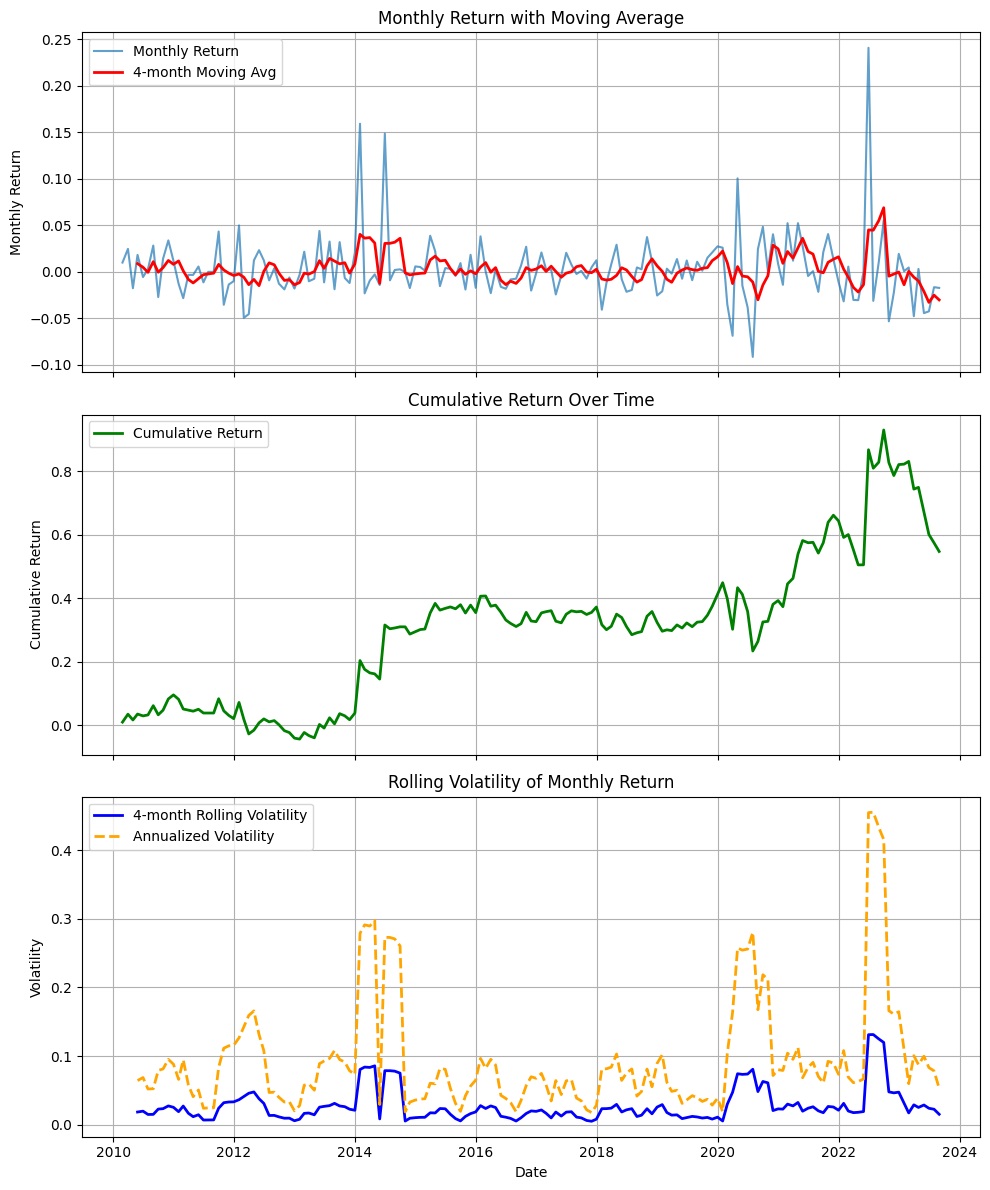

In [156]:
plot_monthly_pnl(realised_h_strat_returns)

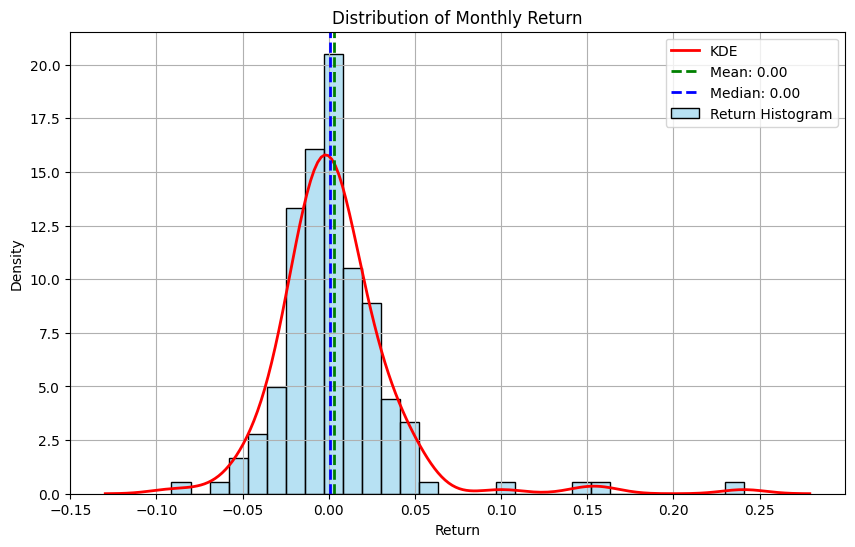

In [157]:
plot_pnl_distribution(realised_h_strat_returns)

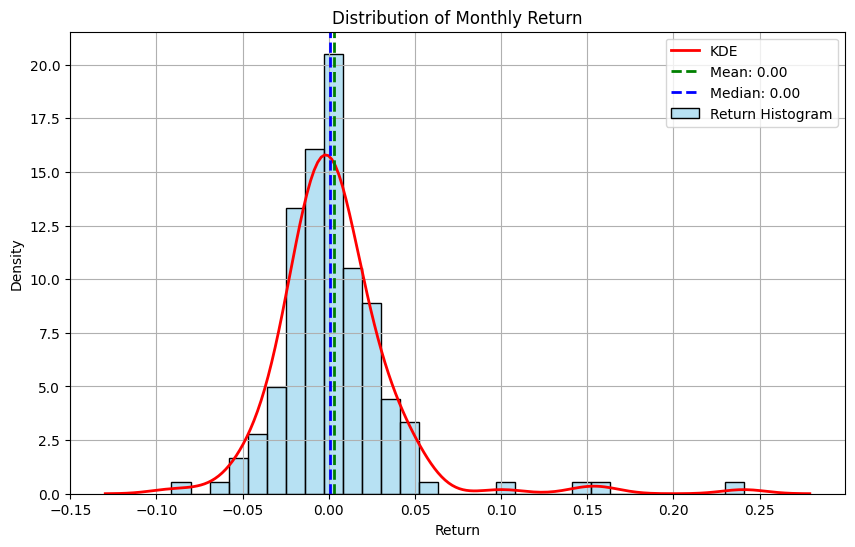

In [158]:
plot_pnl_distribution(realised_h_strat_returns)

### **Performance of portfolios sorted on implied roughness**

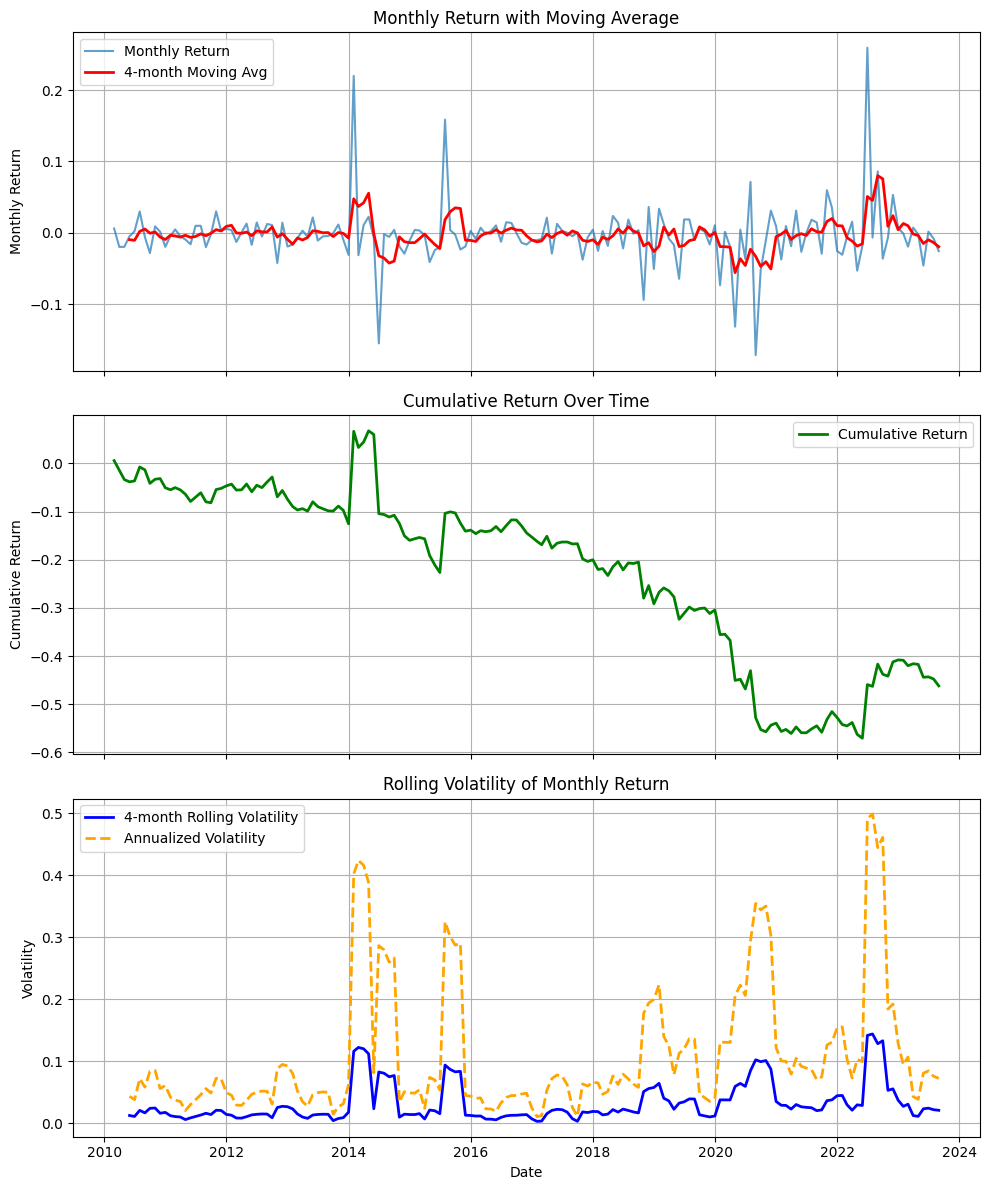

In [159]:
plot_monthly_pnl(implied_h_strat_returns)

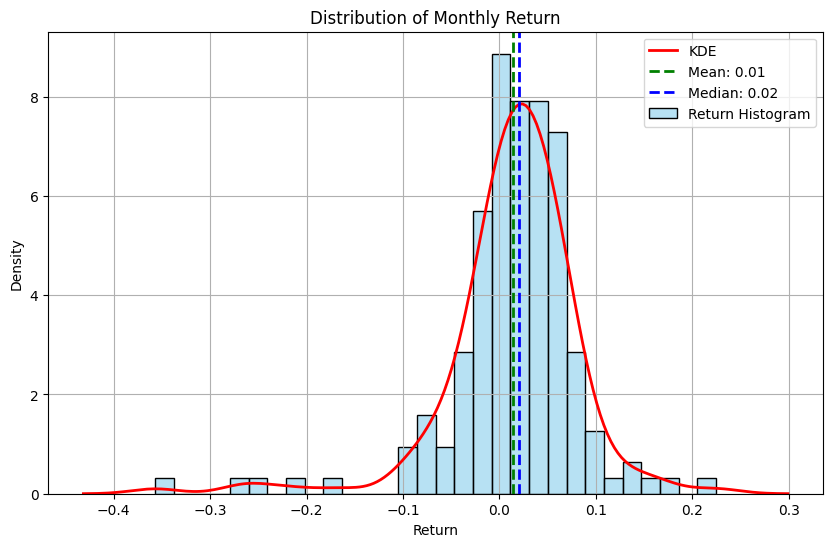

In [ ]:
plot_pnl_distribution(implied_h_strat_returns)

In [ ]:
calculate_performance_metrics(implied_h_strat_returns)

# Controlling for Other Factors


## Liquidity

In [180]:
realized_H=pd.read_csv('Realized_H/Realized_H_Data.csv')
implied_H=pd.read_csv('Implied_H/H_values_output.csv')
daily_ticker=pd.read_csv('daily_ticker_prices.csv')
industries = pd.read_csv('./industry.csv')

In [181]:
industries['industry'] = industries.industry.str.replace('CRSP ', '', regex=True)
industries['industry'] = industries.industry.str.replace(' Index', '', regex=True)
industries['top_tickers'] = industries['top_tickers'].str.split()
industries = industries.explode('top_tickers').reset_index(drop=True)
industries.rename(columns={'top_tickers': 'ticker'}, inplace=True)

industry ticker
0  US Consumer Discretionary   AMZN
1  US Consumer Discretionary   TSLA
2  US Consumer Discretionary     HD
3  US Consumer Discretionary    WMT
4  US Consumer Discretionary    MCD

In [182]:
daily_ticker.drop(['PERMNO','RET','PRC'],axis=1,inplace= True)
daily_ticker.rename(columns={'TICKER':'ticker','VOL':'vol'},inplace=True)
daily_ticker['date']=pd.to_datetime(daily_ticker['date'])
daily_ticker['year']=daily_ticker['date'].dt.year
daily_ticker['month']=daily_ticker['date'].dt.month
monthly_ticker_volume=daily_ticker.drop(columns=['date']).groupby(['year','month','ticker']).agg({'vol':'mean'}).reset_index()
monthly_ticker_volume['log_vol'] = np.log(monthly_ticker_volume['vol'])
monthly_ticker_volume.drop(columns=['vol'],inplace=True)

In [183]:
realized_H['date']=pd.to_datetime(realized_H['date'])
realized_H['year']=realized_H['date'].dt.year
realized_H['month']=realized_H['date'].dt.month
realized_H.drop(columns=['date','price'],inplace=True)
realized_H

Realized_H ticker  year  month
0        0.137720   AAPL  2010      1
1        0.130794   AAPL  2010      2
2        0.071049   AAPL  2010      3
3        0.137683   AAPL  2010      4
4        5.734701   AAPL  2010      5
...           ...    ...   ...    ...
15457    0.023559    XOM  2023      4
15458    0.016606    XOM  2023      5
15459    0.052514    XOM  2023      6
15460    0.068541    XOM  2023      7
15461    0.011739    XOM  2023      8

[15462 rows x 4 columns]

In [184]:
implied_H.drop(columns=['date','close'],inplace=True)
implied_H.rename(columns={'H_value':'Implied_H'},inplace=True)
implied_H=implied_H.groupby(['ticker','year','month']).agg({'Implied_H':'mean'}).reset_index()
implied_H

ticker  year  month  Implied_H
0       AAPL  2010      1   0.403449
1       AAPL  2010      2   0.175181
2       AAPL  2010      3   0.274820
3       AAPL  2010      4   0.421337
4       AAPL  2010      5   0.024329
...      ...   ...    ...        ...
14666    XOM  2023      4   0.161154
14667    XOM  2023      5   0.134262
14668    XOM  2023      6   0.260377
14669    XOM  2023      7   0.274694
14670    XOM  2023      8   0.205694

[14671 rows x 4 columns]

### H vs Log - volume

In [185]:
Realized_H_vs_volume=pd.merge(realized_H,monthly_ticker_volume,on=['year','month','ticker'],how='inner')
Implied_H_vs_volume=pd.merge(implied_H,monthly_ticker_volume,on=['year','month','ticker'],how='inner')
Realized_H_vs_volume=Realized_H_vs_volume.merge(industries,on='ticker',how='inner')
Implied_H_vs_volume=Implied_H_vs_volume.merge(industries,on='ticker',how='inner')

In [188]:
# Realized_H_vs_volume=Realized_H_vs_volume[Realized_H_vs_volume['Realized_H'].between(0,1)]

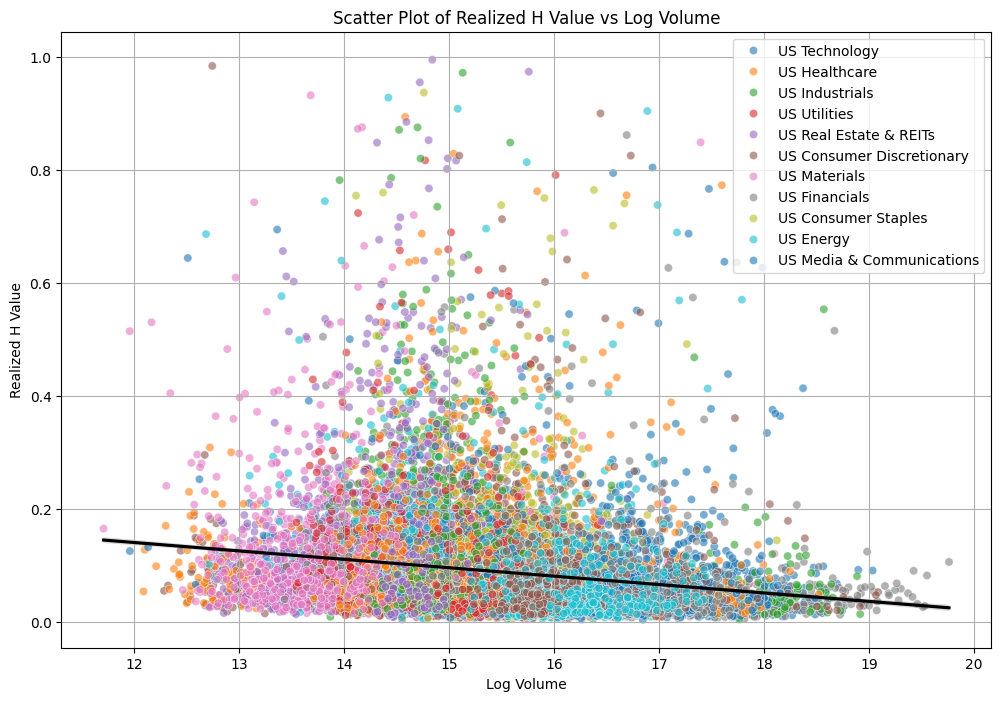

In [189]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.scatterplot(data=Realized_H_vs_volume, x='log_vol', y='Realized_H', hue='industry', palette='tab10', alpha=0.6)
sns.regplot(data=Realized_H_vs_volume, x='log_vol', y='Realized_H', scatter=False, color='black', line_kws={'label': 'Linear Regression'})
plt.xlabel('Log Volume')
plt.ylabel('Realized H Value')
plt.title('Scatter Plot of Realized H Value vs Log Volume')
plt.legend()
plt.grid(True)
plt.show()

In [190]:
# Implied_H_vs_volume=Implied_H_vs_volume[Implied_H_vs_volume['Implied_H'].between(0,1)]

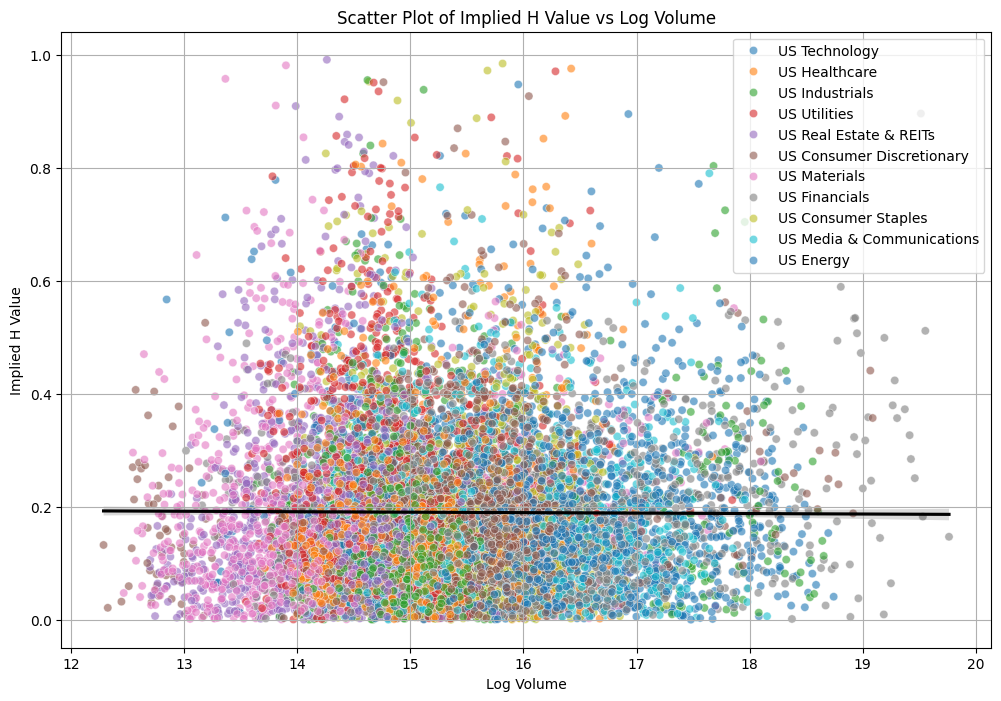

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.scatterplot(data=Implied_H_vs_volume, x='log_vol', y='Implied_H', hue='industry', palette='tab10', alpha=0.6)
sns.regplot(data=Implied_H_vs_volume, x='log_vol', y='Implied_H', scatter=False, color='black', line_kws={'label': 'Linear Regression'})
plt.xlabel('Log Volume')
plt.ylabel('Implied H Value')
plt.title('Scatter Plot of Implied H Value vs Log Volume')
plt.legend()
plt.grid(True)
plt.show()

In [221]:
daily_ticker = pd.read_csv('daily_ticker_prices.csv')
daily_ticker.drop(['PERMNO', 'RET'], axis=1, inplace=True)
daily_ticker.rename(columns={'TICKER': 'ticker', 'VOL': 'vol', 'PRC': 'price'}, inplace=True)
daily_ticker['return'] = daily_ticker.groupby('ticker')['price'].pct_change()
daily_ticker['date']=pd.to_datetime(daily_ticker['date'])
daily_ticker['year']=daily_ticker['date'].dt.year
daily_ticker['month']=daily_ticker['date'].dt.month
daily_ticker['dollar_volume']=daily_ticker['price']*daily_ticker['vol']
daily_ticker['abs_return']=daily_ticker['return'].abs()
daily_ticker.drop(columns=['vol','price','date','return'],inplace=True)
daily_ticker.dropna(inplace=True)
monthly_ticker=daily_ticker.groupby(['year','month','ticker']).agg({'abs_return':'sum','dollar_volume':'sum'}).reset_index()
monthly_ticker['amihud_illiquidity']=monthly_ticker['abs_return']/monthly_ticker['dollar_volume']
monthly_ticker['log_illiquidity']=np.log(monthly_ticker['amihud_illiquidity'])
monthly_ticker.drop(columns=['abs_return','dollar_volume','amihud_illiquidity'],inplace=True)
monthly_ticker

year  month ticker  log_illiquidity
0      2010      1   AAPL       -26.519384
1      2010      1    ABT       -24.696415
2      2010      1    ACN       -23.859347
3      2010      1    ADP       -23.708175
4      2010      1    AEP       -23.446516
...     ...    ...    ...              ...
17682  2023      8   WELL       -23.444051
17683  2023      8    WFC       -24.936316
17684  2023      8    WMB       -24.036655
17685  2023      8    WMT       -25.694728
17686  2023      8    XOM       -25.655432

[17687 rows x 4 columns]

### H vs Log - illiquidity

In [222]:
Realized_H_vs_illiquidity=pd.merge(realized_H,monthly_ticker,on=['year','month','ticker'],how='inner')
Implied_H_vs_illiquidity=pd.merge(implied_H,monthly_ticker,on=['year','month','ticker'],how='inner')
Realized_H_vs_illiquidity=Realized_H_vs_illiquidity.merge(industries,on='ticker',how='inner')
Implied_H_vs_illiquidity=Implied_H_vs_illiquidity.merge(industries,on='ticker',how='inner')

In [223]:
Realized_H_vs_illiquidity=Realized_H_vs_illiquidity[Realized_H_vs_illiquidity['Realized_H'].between(0,1)]

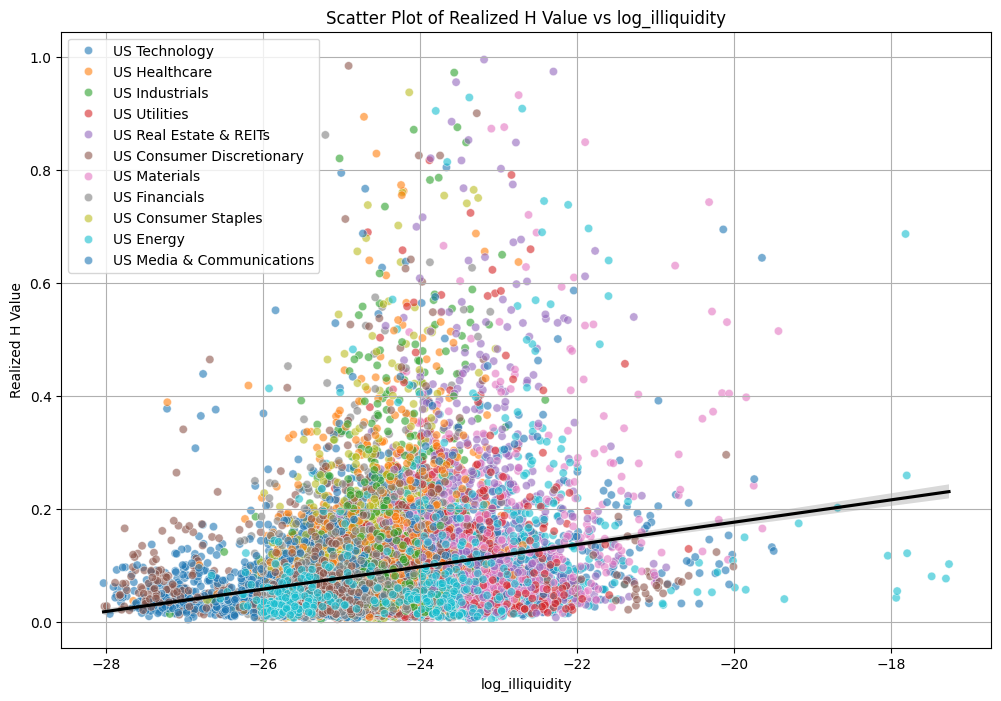

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.scatterplot(data=Realized_H_vs_illiquidity, x='log_illiquidity', y='Realized_H', hue='industry', palette='tab10', alpha=0.6)
sns.regplot(data=Realized_H_vs_illiquidity, x='log_illiquidity', y='Realized_H', scatter=False, color='black', line_kws={'label': 'Linear Regression'})
plt.xlabel('log_illiquidity')
plt.ylabel('Realized H Value')
plt.title('Scatter Plot of Realized H Value vs log_illiquidity')
plt.legend()
plt.grid(True)
plt.show()

In [225]:
# Implied_H_vs_illiquidity=Implied_H_vs_illiquidity[Implied_H_vs_illiquidity['Implied_H'].between(0,1)]

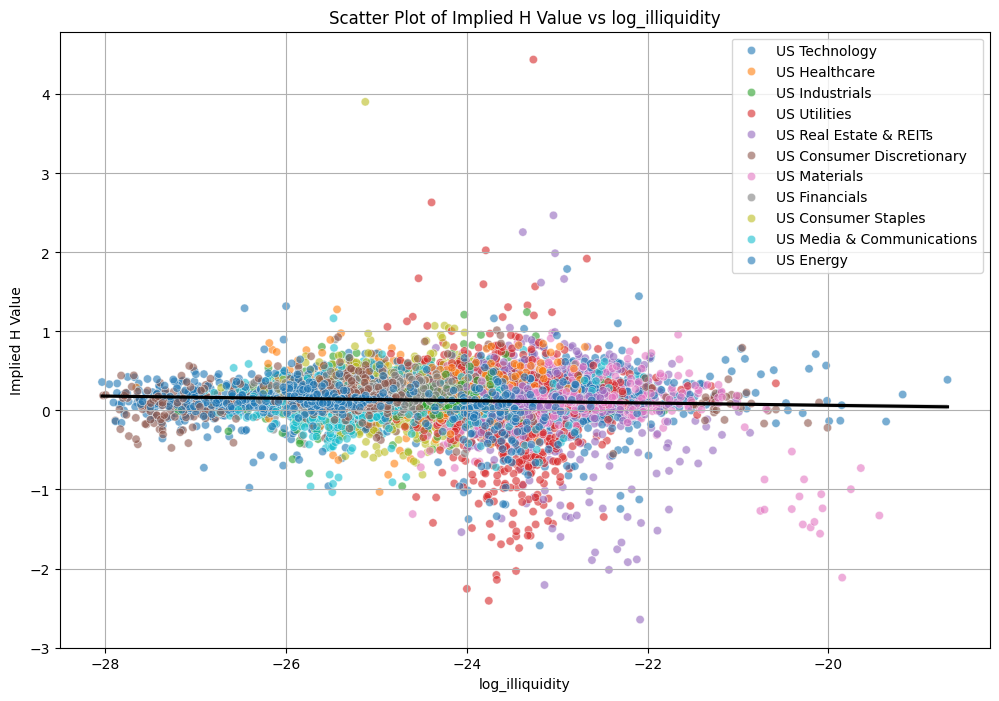

In [226]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.scatterplot(data=Implied_H_vs_illiquidity, x='log_illiquidity', y='Implied_H', hue='industry', palette='tab10', alpha=0.6)
sns.regplot(data=Implied_H_vs_illiquidity, x='log_illiquidity', y='Implied_H', scatter=False, color='black', line_kws={'label': 'Linear Regression'})
plt.xlabel('log_illiquidity')
plt.ylabel('Implied H Value')
plt.title('Scatter Plot of Implied H Value vs log_illiquidity')
plt.legend()
plt.grid(True)
plt.show()

## Implied volatility and skewness

## Double Sorts

## Fama Macbeth Regressions

In [259]:
daily_ticker = pd.read_csv('daily_ticker_prices.csv')
daily_ticker.drop(['PERMNO', 'RET'], axis=1, inplace=True)
daily_ticker.rename(columns={'TICKER': 'ticker', 'VOL': 'volume', 'PRC': 'price'}, inplace=True)
daily_ticker['return'] = daily_ticker.groupby('ticker')['price'].pct_change()
daily_ticker['date']=pd.to_datetime(daily_ticker['date'])
daily_ticker['year']=daily_ticker['date'].dt.year
daily_ticker['month']=daily_ticker['date'].dt.month
daily_ticker['dollar_volume']=daily_ticker['price']*daily_ticker['volume']
daily_ticker.drop(columns=['price','date'],inplace=True)
daily_ticker.dropna(inplace=True)
monthly_ticker=daily_ticker.groupby(['year','month','ticker']).agg({'dollar_volume':'sum','volume':'sum','return':lambda x: (1+x).prod()-1}).reset_index()
monthly_ticker['log_dollar_volume']=np.log(monthly_ticker['dollar_volume'])
monthly_ticker.rename(columns={'return':'monthly_return'},inplace=True)
monthly_ticker['log_volume']=np.log(monthly_ticker['volume'])
monthly_ticker.drop(columns=['dollar_volume','volume'],inplace=True)
monthly_ticker.sort_values(['year','month'],inplace=True)
monthly_ticker['6m_return'] = monthly_ticker.groupby('ticker')['monthly_return'].rolling(window=6).apply(lambda x: (1+x).prod()-1).reset_index(level=0, drop=True)
monthly_ticker['12m_return'] = monthly_ticker.groupby('ticker')['monthly_return'].rolling(window=12).apply(lambda x: (1+x).prod()-1).reset_index(level=0, drop=True)
monthly_ticker['past_skewness'] = monthly_ticker.groupby('ticker')['monthly_return'].expanding().skew().reset_index(level=0, drop=True)
monthly_ticker['past_volatility'] = monthly_ticker.groupby('ticker')['monthly_return'].expanding().std().reset_index(level=0, drop=True)
monthly_ticker.dropna(inplace=True)
monthly_ticker

year  month ticker  monthly_return  log_dollar_volume  log_volume  \
1141   2010     12   AAPL        0.036670          25.139612   19.368537   
1142   2010     12    ABT        0.030101          22.833806   18.971522   
1143   2010     12    ACN        0.119344          22.112764   18.257086   
1144   2010     12    ADP        0.038367          21.780573   17.939061   
1145   2010     12    AEP        0.010674          21.387586   17.808225   
...     ...    ...    ...             ...                ...         ...   
17682  2023      8   WELL        0.008886          21.950705   17.533015   
17683  2023      8    WFC       -0.105503          23.226105   19.465160   
17684  2023      8    WMB        0.002322          22.233200   18.687288   
17685  2023      8    WMT        0.017203          23.755096   18.687355   
17686  2023      8    XOM        0.036833          24.259097   19.571104   

       6m_return  12m_return  past_skewness  past_volatility  
1141    0.282392    0.507219       0.012691         0.080082  
1142    0.024156   -0.120272      -0.235168         0.045852  
1143    0.254592    0.152603      -0.074525         0.081809  
1144    0.149528    0.080551       0.050514         0.050779  
1145    0.113932    0.029765       0.930949         0.046008  
...          ...         ...            ...              ...  
17682   0.118187    0.081279      -1.350497         0.086515  
17683  -0.117169   -0.055365      -0.300143         0.075149  
17684   0.147176    0.014693      -0.058119         0.094191  
17685   0.144093    0.226782      -0.176836         0.050182  
17686   0.011646    0.163197       0.290193         0.070974  

[16276 rows x 10 columns]

In [301]:
def Famamacbeth(monthly_ticker,H_val,H_form='Implied_all'):     #Implied_all,Implied,Realized_all,Realized
    df_reg=monthly_ticker.copy()
    df_reg=df_reg.merge(H_val,on=['year','month','ticker'],how='inner')
    unique_year_month_pairs = df_reg[['year', 'month']].drop_duplicates().sort_values(['year', 'month']).values.tolist()

    betas={}
    tvals_abs={}
    regressors=df_reg.drop(columns=['year','month','ticker','monthly_return']).columns
    for time_point in unique_year_month_pairs:
        year, month = time_point
        df_time=df_reg[(df_reg['year'] == year) & (df_reg['month'] == month)]
        if H_form=='Implied':
            X=sm.add_constant(df_time['Implied_H'])
        elif H_form=='Implied_all':
            X=sm.add_constant(df_time.drop(columns=['year','month','ticker','monthly_return']))
        elif H_form=='Realized':
            X=sm.add_constant(df_time['Realized_H'])
        elif H_form=='Realized_all':
            X=sm.add_constant(df_time.drop(columns=['year','month','ticker','monthly_return']))
        y=df_time['monthly_return']
        regress=sm.OLS(y,X).fit()
        betas[(year, month)]=regress.params
        tvals_abs[(year, month)]=regress.tvalues.abs()

    betas_df = pd.DataFrame(betas).T
    betas_mean = betas_df.mean()
    tvals_abs_df = pd.DataFrame(tvals_abs).T
    tvals_abs_mean = tvals_abs_df.mean()
    
    return betas_mean,tvals_abs_mean

In [ ]:
a,b=Famamacbeth(monthly_ticker,implied_H,H_form='Implied_all')
print('Betas are',a)
print('Corresponding t-values are',b)

NameError: name 'Famamacbeth' is not defined